# Signate開始時のお約束

In [195]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [196]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [197]:
!pip install signate

In [198]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [199]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [200]:
!pip install kanjize

In [201]:
!pip install optuna

In [202]:
!pip install shap

In [203]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [362]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [363]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]
    # 数値変換し5足す
    tmp = int(tmp)
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  if (await self.run_code(code, result,  async_=asy)):


<Axes: >

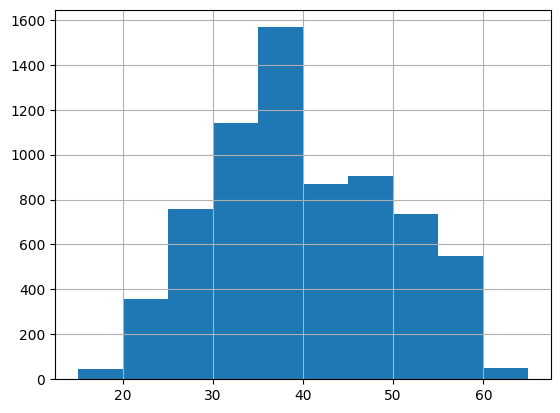

In [364]:
all_df["Age"].hist()

In [365]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損を埋める
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

In [366]:
# 分類の確認
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4462
Company Invited,2516


In [367]:
#########################
# "CityTier"の処理 #
#########################
# 分類の確認
all_df["CityTier"].value_counts()
# all_df["CityTier"].isnull().sum()

,count
CityTier,
2,3160
1,2991
3,827


In [368]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

<Axes: >

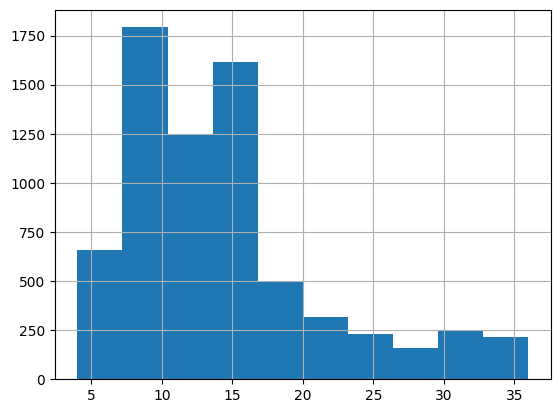

In [369]:
# 分布の確認
all_df["DurationOfPitch"].hist()

In [370]:
####################
# "Occupation"の処理 #
####################
# 個人事業主/会社員/大企業の3択のためホットエンコードにする
all_df["Occupation"].value_counts()
# all_df["Occupation"].isnull().sum()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [371]:
##################
# "Genger"の処理 #
##################
# all_df["Gender"].isnull().sum()
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])

  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"

  else:
    all_df.loc[i,"Gender"] = "Female"

In [372]:
# 分類の確認
all_df["Gender"].value_counts()

,count
Gender,
Female,5946
Male,1032


In [373]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"].value_counts()
# all_df["NumberOfPersonVisiting"].isnull().sum()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [374]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# all_df["NumberOfFollowups"].value_counts()
# all_df["NumberOfFollowups"].isnull().sum()
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

In [375]:
# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

In [376]:
# 分布の確認
all_df["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,2834
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


In [377]:
##########################
# "ProductPitched"の処理 #
##########################
# ind_name = all_df["ProductPitched"].value_counts().index.values
# all_df["ProductPitched"].isnull().sum()

In [378]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [379]:
# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

In [380]:
# 分布の確認
all_df["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,2347
Deluxe,2091
Standard,1614
SuperDeluxe,640
King,286


In [381]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# all_df["PreferredPropertyStar"].isnull().sum()

# 2引いて揃える
# all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [382]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

<Axes: >

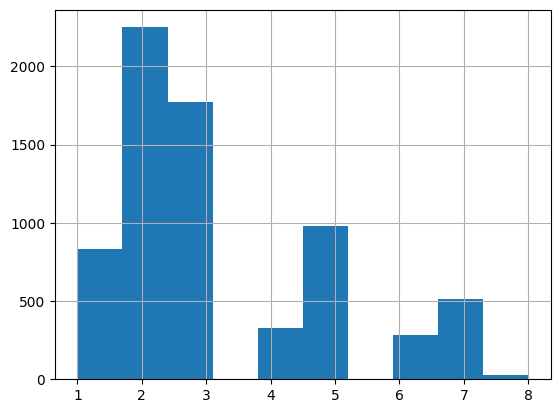

In [383]:
# ヒストグラムの確認
all_df["NumberOfTrips"].hist()

In [384]:
#########################
# "Passport"の処理 #
#########################
# all_df["Passport"].isnull().sum()
all_df["Passport"].value_counts()

,count
Passport,
0,6288
1,690


<Axes: >

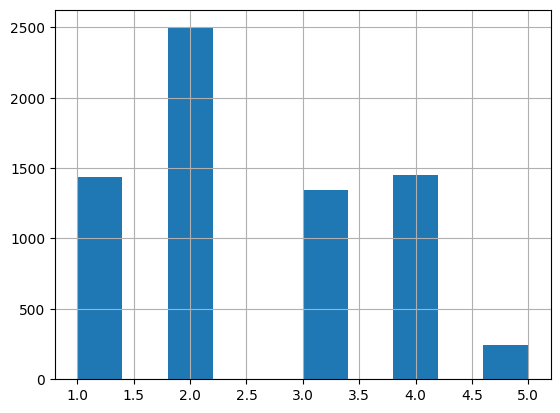

In [385]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
# all_df["PitchSatisfactionScore"].isnull().sum()
# all_df["PitchSatisfactionScore"].value_counts()
all_df["PitchSatisfactionScore"].hist()

In [386]:
#########################
# "Designation"の処理 #
#########################
# all_df["Designation"].isnull().sum()
# all_df["Designation"].value_counts()

In [387]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [388]:
# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

In [389]:
# 分類の確認
all_df["Designation"].value_counts()

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


In [390]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

<Axes: >

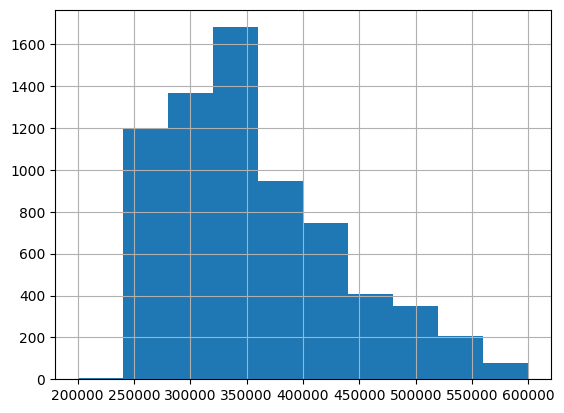

In [391]:
# 分布の確認
all_df["MonthlyIncome"].hist()

In [392]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [393]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [394]:
# 車保有率
all_df["CarHolder"].value_counts()

,count
CarHolder,
0,4408
1,2570


In [395]:
# 子供の数
all_df["NumofChild"].value_counts()

,count
NumofChild,
0,5015
1,1347
2,571
3,45


In [396]:
# 婚姻歴
all_df["Married"].value_counts()

,count
Married,
Married,2846
Single,2444
Divorce,1688


# 特徴量エンジニアリング

In [397]:
# 「Dsignation」をラベルエンコード
all_df["Designation_LE"] = 1
all_df.loc[all_df["Designation"]=="Executive","Designation_LE"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation_LE"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation_LE"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation_LE"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation_LE"] = 1

# 「Occupation」をラベルエンコード
all_df["Occupation_LE"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","Occupation_LE"] = 3
all_df.loc[all_df["Occupation"]=="Small Business","Occupation_LE"] = 2
all_df.loc[all_df["Occupation"]=="Salaried","Occupation_LE"] = 1

# 「CarHolder」をラベルエンコード
all_df["CarHolder_LE"] = all_df["CarHolder"] + 1

# 「Gender」をラベルエンコード
all_df["Gender_LE"] = 1
all_df.loc[all_df["Gender"]=="Female","Gender_LE"]=2
all_df.loc[all_df["Gender"]=="Male","Gender_LE"]=2

# 「ProductPitched」をラベルエンコード
all_df["ProductPitched_LE"] = 1
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched_LE"]=5
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched_LE"]=4
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched_LE"]=3
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched_LE"]=2
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched_LE"]=1

# 「Married」をラベルエンコード
all_df["Married_LE"] = 1
all_df.loc[all_df["Married"]=="Married","Married_LE"]=3
all_df.loc[all_df["Married"]=="Divorce","Married_LE"]=2
all_df.loc[all_df["Married"]=="Single","Married_LE"]=1

# 「TypeofContact」をラベルエンコード
all_df["TypeofContact_LE"] = 1
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact_LE"]=2
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact_LE"]=1

In [398]:
# 【異常値の排除】
# 年齢でクリッピングする(18〜60歳)
all_df["Age"] = all_df["Age"].clip(18,60)

In [350]:
# # 給与の区分
# # 〜25万円（若年層、アルバイト層）
# # 25〜35万円（新卒〜20代後半）
# # 35〜45万円（中堅層）
# # 45〜55万円（管理職候補）
# # 55万円〜（管理職・富裕層）
# all_df["IncomeRank"] = 0
# all_df.loc[all_df["MonthlyIncome"]<250000,"IncomeRank"] = 1
# all_df.loc[(all_df["MonthlyIncome"]>=250000)&(all_df["MonthlyIncome"]<350000),"IncomeRank"] = 2
# all_df.loc[(all_df["MonthlyIncome"]>=350000)&(all_df["MonthlyIncome"]<450000),"IncomeRank"] = 3
# all_df.loc[(all_df["MonthlyIncome"]>=450000)&(all_df["MonthlyIncome"]<550000),"IncomeRank"] = 4
# all_df.loc[(all_df["MonthlyIncome"]>=550000),"IncomeRank"] = 5

In [399]:
# LOGを取る
all_df["MonthlyIncomeLOG"] = np.log1p(all_df["MonthlyIncome"])  # 月収はLogを取る
all_df["AgeLOG"] = np.log1p(all_df["Age"])  # 年齢はLogを取る

In [400]:
# # クロス特徴量の追加(確定)
# 「役職」x「商品ランク」
all_df["Designation_LE_ProductPitched_LE"] = all_df["Designation_LE"] * all_df["ProductPitched_LE"]

In [359]:
# all_df["IncomeRank_AgeLOG"] = all_df["IncomeRank"] * all_df["AgeLOG"]

In [360]:
# all_df = all_df.drop("IncomeRank", axis=1)

In [ ]:
# # クロス特徴量の追加
# 「月収」x「ホテルランク」
# all_df["MonthlyIncomeLOG_PreferredPropertyStar_LE

In [ ]:
all_df = all_df.drop("MonthlyIncomeLOG_CityTier", axis=1)

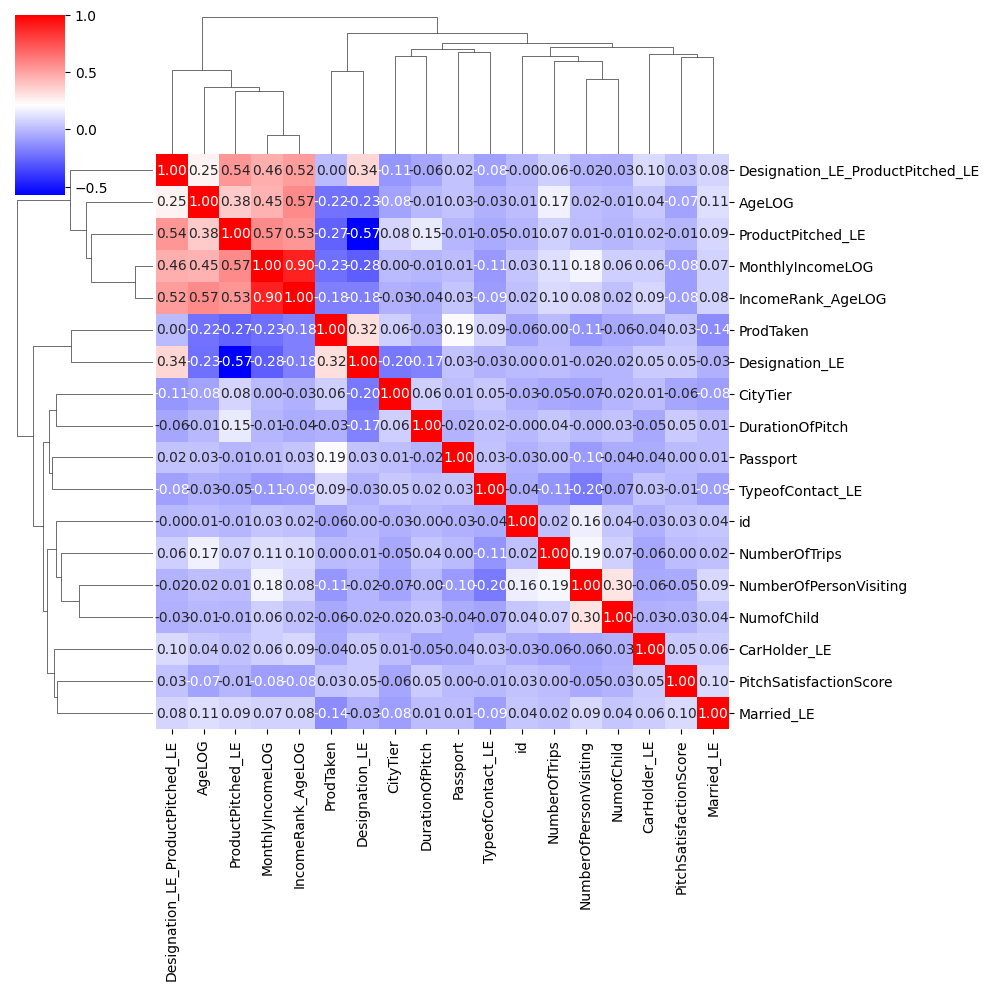

In [361]:
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()

# sns.heatmap(all_df_corr,annot=True,cmap="bwr")
# sns.heatmap(all_df_corr,annot=False,cmap="bwr")
# plt.show()
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [308]:
all_df.columns

Index(['id', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'ProdTaken',
       'NumofChild', 'Designation_LE', 'CarHolder_LE', 'ProductPitched_LE',
       'Married_LE', 'TypeofContact_LE', 'IncomeRank', 'MonthlyIncomeLOG',
       'AgeLOG', 'Designation_LE_ProductPitched_LE'],
      dtype='object')

In [401]:
# エンコード前のラベルを抹消する
all_df = all_df.drop("Designation", axis=1)
all_df = all_df.drop("Occupation", axis=1)
all_df = all_df.drop("Gender", axis=1)
all_df = all_df.drop("ProductPitched", axis=1)
all_df = all_df.drop("Married", axis=1)
all_df = all_df.drop("CarHolder", axis=1)
all_df = all_df.drop("TypeofContact", axis=1)

In [402]:
# 検討の結果、重要度が低いものを抹消する
all_df = all_df.drop("Occupation_LE", axis=1)
all_df = all_df.drop("NumberOfFollowups", axis=1)
all_df = all_df.drop("PreferredPropertyStar", axis=1)
all_df = all_df.drop("Gender_LE", axis=1)
all_df = all_df.drop("MonthlyIncome", axis=1)
all_df = all_df.drop("Age", axis=1)

In [ ]:
all_df.columns

Index(['id', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'ProdTaken',
       'NumofChild', 'Designation_LE', 'CarHolder_LE', 'ProductPitched_LE',
       'Married_LE', 'TypeofContact_LE', 'MonthlyIncomeLOG', 'AgeLOG',
       'MonthlyIncomeLOG_AgeLOG'],
      dtype='object')

In [ ]:
# # # 検討の結果、重要度が低いものを抹消する
# RMV3=['NumberOfPersonVisiting',
#        'NumberOfTrips', 'PitchSatisfactionScore',
#        'CarHolder_LE',
#        'TypeofContact_LE', 'MonthlyIncomeLOG',
#        ]
# all_df = all_df.drop(RMV3, axis=1)

# ここから学習

In [403]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [404]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [405]:
# カラムを制限
all_df2 = all_df[FEATURES]

In [406]:
# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

In [407]:
# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)

In [408]:
FEATURES = test.columns

In [256]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      # 'learning_rate': 0.01,

      'num_leaves': trial.suggest_int('num_leaves', 16, 256),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
      'max_depth': trial.suggest_int('max_depth', 3, 12),

      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  score = roc_auc_score(train[TARGET],oof_lgb)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-23 12:08:32,924] A new study created in memory with name: no-name-1b08aa18-4b83-465b-b6c0-e072b8094318
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.990338	valid's auc: 0.814449
#########################
### Fold 2
#########################
[100]	train's auc: 0.991779	valid's auc: 0.832963
#########################
### Fold 3
#########################
[100]	train's auc: 0.991647	valid's auc: 0.797571


[I 2025-05-23 12:08:33,607] Trial 0 finished with value: 0.8271541010770506 and parameters: {'num_leaves': 29, 'min_data_in_leaf': 36, 'feature_fraction': 0.5443136932623744, 'bagging_fraction': 0.8606873749697508, 'bagging_freq': 4, 'lambda_l1': 6.188495392852944e-06, 'lambda_l2': 0.0013420695775102289, 'max_depth': 12}. Best is trial 0 with value: 0.8271541010770506.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.954221	valid's auc: 0.811452
#########################
### Fold 2
#########################
[100]	train's auc: 0.955619	valid's auc: 0.837216
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:35,771] Trial 1 finished with value: 0.8233515397196011 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 76, 'feature_fraction': 0.9916024309246385, 'bagging_fraction': 0.7037416349286336, 'bagging_freq': 3, 'lambda_l1': 2.2793411870830032e-06, 'lambda_l2': 0.0007094469999445046, 'max_depth': 9}. Best is trial 0 with value: 0.8271541010770506.


[100]	train's auc: 0.958355	valid's auc: 0.804263
#########################
### Fold 1
#########################
[100]	train's auc: 0.945548	valid's auc: 0.818238


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.948238	valid's auc: 0.83602
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:36,298] Trial 2 finished with value: 0.8274123349724011 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 91, 'feature_fraction': 0.6266122521445224, 'bagging_fraction': 0.8906222512129441, 'bagging_freq': 7, 'lambda_l1': 8.990474377093046e-05, 'lambda_l2': 0.004420844460121335, 'max_depth': 8}. Best is trial 2 with value: 0.8274123349724011.


[100]	train's auc: 0.948884	valid's auc: 0.806522
#########################
### Fold 1
#########################
[100]	train's auc: 0.954786	valid's auc: 0.808335


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.9537	valid's auc: 0.843174


[I 2025-05-23 12:08:36,877] Trial 3 finished with value: 0.827363916117023 and parameters: {'num_leaves': 17, 'min_data_in_leaf': 55, 'feature_fraction': 0.5756424608265871, 'bagging_fraction': 0.8239342041897533, 'bagging_freq': 6, 'lambda_l1': 8.78238439563019e-06, 'lambda_l2': 1.45520153559314, 'max_depth': 10}. Best is trial 2 with value: 0.8274123349724011.


#########################
### Fold 3
#########################
[100]	train's auc: 0.954827	valid's auc: 0.808022
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.932873	valid's auc: 0.825646
#########################
### Fold 2
#########################
[100]	train's auc: 0.934016	valid's auc: 0.837368
#########################
### Fold 3
#########################
[100]	train's auc: 0.93125	valid's auc: 0.810548


[I 2025-05-23 12:08:37,539] Trial 4 finished with value: 0.8278407073456783 and parameters: {'num_leaves': 211, 'min_data_in_leaf': 75, 'feature_fraction': 0.9270172360444674, 'bagging_fraction': 0.585867003800648, 'bagging_freq': 5, 'lambda_l1': 0.03833057318637329, 'lambda_l2': 9.397378705663289e-08, 'max_depth': 7}. Best is trial 4 with value: 0.8278407073456783.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.993182	valid's auc: 0.808202
#########################
### Fold 2
#########################
[100]	train's auc: 0.994682	valid's auc: 0.820359
#########################
### Fold 3
#########################
[100]	train's auc: 0.994252	valid's auc: 0.800383


[I 2025-05-23 12:08:38,291] Trial 5 finished with value: 0.8211800885527065 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 43, 'feature_fraction': 0.737295881923602, 'bagging_fraction': 0.9749445356920702, 'bagging_freq': 5, 'lambda_l1': 2.1964698763431726e-07, 'lambda_l2': 0.6798194257814644, 'max_depth': 12}. Best is trial 4 with value: 0.8278407073456783.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.997363	valid's auc: 0.796335
#########################
### Fold 2
#########################
[100]	train's auc: 0.998227	valid's auc: 0.827785
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:39,077] Trial 6 finished with value: 0.8176357610906079 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 17, 'feature_fraction': 0.5355298797851983, 'bagging_fraction': 0.6120502878982614, 'bagging_freq': 1, 'lambda_l1': 0.013907613515243986, 'lambda_l2': 1.3539125449944784e-07, 'max_depth': 9}. Best is trial 4 with value: 0.8278407073456783.


[100]	train's auc: 0.998437	valid's auc: 0.786646
#########################
### Fold 1
#########################
[100]	train's auc: 0.923067	valid's auc: 0.816993


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.923071	valid's auc: 0.840292
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:39,542] Trial 7 finished with value: 0.8260303801418134 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 62, 'feature_fraction': 0.7934533676085215, 'bagging_fraction': 0.9302378181950548, 'bagging_freq': 6, 'lambda_l1': 0.5508841136809517, 'lambda_l2': 2.4467109150565286e-06, 'max_depth': 4}. Best is trial 4 with value: 0.8278407073456783.


[100]	train's auc: 0.926882	valid's auc: 0.807087
#########################
### Fold 1
#########################
[100]	train's auc: 0.94513	valid's auc: 0.814818


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.942459	valid's auc: 0.844056
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:40,006] Trial 8 finished with value: 0.8212597779188501 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 19, 'feature_fraction': 0.8414913425021426, 'bagging_fraction': 0.7415043845687217, 'bagging_freq': 7, 'lambda_l1': 0.003678673120140622, 'lambda_l2': 0.003255279443353049, 'max_depth': 4}. Best is trial 4 with value: 0.8278407073456783.


[100]	train's auc: 0.946072	valid's auc: 0.808939
#########################
### Fold 1
#########################
[100]	train's auc: 0.945606	valid's auc: 0.821682


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.944502	valid's auc: 0.839821
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:40,502] Trial 9 finished with value: 0.8260841788700116 and parameters: {'num_leaves': 38, 'min_data_in_leaf': 73, 'feature_fraction': 0.7838317692578554, 'bagging_fraction': 0.629935838826398, 'bagging_freq': 2, 'lambda_l1': 1.420052898602756e-07, 'lambda_l2': 0.008576556867065228, 'max_depth': 10}. Best is trial 4 with value: 0.8278407073456783.


[100]	train's auc: 0.948685	valid's auc: 0.808271
#########################
### Fold 1
#########################
[100]	train's auc: 0.884365	valid's auc: 0.827449


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[200]	train's auc: 0.911112	valid's auc: 0.828262
#########################
### Fold 2
#########################
[100]	train's auc: 0.882963	valid's auc: 0.853222
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:41,168] Trial 10 finished with value: 0.8295259525064826 and parameters: {'num_leaves': 249, 'min_data_in_leaf': 99, 'feature_fraction': 0.9884844330176861, 'bagging_fraction': 0.5493827046429722, 'bagging_freq': 4, 'lambda_l1': 2.4363328200885133, 'lambda_l2': 1.668656196632231e-08, 'max_depth': 6}. Best is trial 10 with value: 0.8295259525064826.


[100]	train's auc: 0.88929	valid's auc: 0.804518
[200]	train's auc: 0.91206	valid's auc: 0.805326
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.853194	valid's auc: 0.824238
[200]	train's auc: 0.857095	valid's auc: 0.824881
#########################
### Fold 2
#########################
[100]	train's auc: 0.837786	valid's auc: 0.857077


[I 2025-05-23 12:08:41,680] Trial 11 finished with value: 0.8298480723915688 and parameters: {'num_leaves': 251, 'min_data_in_leaf': 100, 'feature_fraction': 0.9881046829177126, 'bagging_fraction': 0.5056095886994303, 'bagging_freq': 4, 'lambda_l1': 9.04641891688098, 'lambda_l2': 1.2725769835223736e-08, 'max_depth': 6}. Best is trial 11 with value: 0.8298480723915688.


[200]	train's auc: 0.841692	valid's auc: 0.857663
#########################
### Fold 3
#########################
[100]	train's auc: 0.860467	valid's auc: 0.807309
[200]	train's auc: 0.862743	valid's auc: 0.808894
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.861293	valid's auc: 0.828794
[200]	train's auc: 0.873138	valid's auc: 0.830588
[300]	train's auc: 0.878818	valid's auc: 0.830697
#########################
### Fold 2
#########################
[100]	train's auc: 0.853878	valid's auc: 0.855204
[200]	train's auc: 0.8696	valid's auc: 0.857645
[300]	train's auc: 0.877652	valid's auc: 0.857138
#########################
### Fold 3
#########################
[100]	train's auc: 0.869463	valid's auc: 0.814347
[200]	train's auc: 0.873108	valid's auc: 0.815574


[I 2025-05-23 12:08:42,577] Trial 12 finished with value: 0.8341381847233131 and parameters: {'num_leaves': 254, 'min_data_in_leaf': 96, 'feature_fraction': 0.9940112643833676, 'bagging_fraction': 0.5155550961058424, 'bagging_freq': 3, 'lambda_l1': 6.556785111497092, 'lambda_l2': 1.035016558126873e-08, 'max_depth': 6}. Best is trial 12 with value: 0.8341381847233131.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.854676	valid's auc: 0.826038
[200]	train's auc: 0.857167	valid's auc: 0.826769
#########################
### Fold 2
#########################
[100]	train's auc: 0.844907	valid's auc: 0.856775
[200]	train's auc: 0.851049	valid's auc: 0.859083
#########################
### Fold 3
#########################
[100]	train's auc: 0.862363	valid's auc: 0.805514


[I 2025-05-23 12:08:43,282] Trial 13 finished with value: 0.8294331497003411 and parameters: {'num_leaves': 249, 'min_data_in_leaf': 90, 'feature_fraction': 0.8881560126195391, 'bagging_fraction': 0.5017725438730611, 'bagging_freq': 3, 'lambda_l1': 8.396103120506172, 'lambda_l2': 6.621939536626095e-06, 'max_depth': 6}. Best is trial 12 with value: 0.8341381847233131.


[200]	train's auc: 0.868452	valid's auc: 0.809152
[300]	train's auc: 0.871752	valid's auc: 0.811344
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.876369	valid's auc: 0.825736
[200]	train's auc: 0.90029	valid's auc: 0.828026
#########################
### Fold 2
#########################
[100]	train's auc: 0.876836	valid's auc: 0.84979
#########################
### Fold 3
#########################
[100]	train's auc: 0.886616	valid's auc: 0.817028


[I 2025-05-23 12:08:43,875] Trial 14 finished with value: 0.8343725454330259 and parameters: {'num_leaves': 226, 'min_data_in_leaf': 98, 'feature_fraction': 0.9223650704676095, 'bagging_fraction': 0.5056717450612697, 'bagging_freq': 3, 'lambda_l1': 0.19377761654379674, 'lambda_l2': 2.6368840861638206e-06, 'max_depth': 3}. Best is trial 14 with value: 0.8343725454330259.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.910778	valid's auc: 0.822099
#########################
### Fold 2
#########################
[100]	train's auc: 0.908348	valid's auc: 0.848534
#########################
### Fold 3
#########################
[100]	train's auc: 0.914806	valid's auc: 0.812146


[I 2025-05-23 12:08:44,413] Trial 15 finished with value: 0.8272966677067753 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 84, 'feature_fraction': 0.915034556038559, 'bagging_fraction': 0.6879527858241488, 'bagging_freq': 2, 'lambda_l1': 0.1636174331150965, 'lambda_l2': 1.278562291559102e-05, 'max_depth': 4}. Best is trial 14 with value: 0.8343725454330259.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.896041	valid's auc: 0.82535
#########################
### Fold 2
#########################
[100]	train's auc: 0.892529	valid's auc: 0.854304
#########################
### Fold 3
#########################
[100]	train's auc: 0.900918	valid's auc: 0.815261


[I 2025-05-23 12:08:44,926] Trial 16 finished with value: 0.8348305071068121 and parameters: {'num_leaves': 218, 'min_data_in_leaf': 60, 'feature_fraction': 0.6879123260054805, 'bagging_fraction': 0.6563700517665518, 'bagging_freq': 2, 'lambda_l1': 0.0014451377817200246, 'lambda_l2': 8.148088435678957e-07, 'max_depth': 3}. Best is trial 16 with value: 0.8348305071068121.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.896716	valid's auc: 0.825211
#########################
### Fold 2
#########################


[I 2025-05-23 12:08:45,388] Trial 17 finished with value: 0.8328315481122026 and parameters: {'num_leaves': 222, 'min_data_in_leaf': 57, 'feature_fraction': 0.6800934274883139, 'bagging_fraction': 0.6573607206928667, 'bagging_freq': 1, 'lambda_l1': 0.000703619203988183, 'lambda_l2': 8.68813616597567e-05, 'max_depth': 3}. Best is trial 16 with value: 0.8348305071068121.


[100]	train's auc: 0.892003	valid's auc: 0.855549
#########################
### Fold 3
#########################
[100]	train's auc: 0.904531	valid's auc: 0.812965


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.908196	valid's auc: 0.820334
#########################
### Fold 2
#########################
[100]	train's auc: 0.902858	valid's auc: 0.855597
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:47,459] Trial 18 finished with value: 0.832126784772808 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 31, 'feature_fraction': 0.7002173318096533, 'bagging_fraction': 0.7782528494894437, 'bagging_freq': 2, 'lambda_l1': 0.0003630918144570854, 'lambda_l2': 3.742240736650577e-07, 'max_depth': 3}. Best is trial 16 with value: 0.8348305071068121.


[100]	train's auc: 0.910009	valid's auc: 0.810008
#########################
### Fold 1
#########################
[100]	train's auc: 0.937524	valid's auc: 0.817422


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.940334	valid's auc: 0.83367
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:48,027] Trial 19 finished with value: 0.8265804721376386 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 47, 'feature_fraction': 0.6629692620787365, 'bagging_fraction': 0.5680761983312577, 'bagging_freq': 1, 'lambda_l1': 0.003000024614968475, 'lambda_l2': 6.860612500910768e-05, 'max_depth': 5}. Best is trial 16 with value: 0.8348305071068121.


[100]	train's auc: 0.938126	valid's auc: 0.806789
#########################
### Fold 1
#########################
[100]	train's auc: 0.895886	valid's auc: 0.828643


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.889294	valid's auc: 0.856419
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:48,513] Trial 20 finished with value: 0.8353853064913546 and parameters: {'num_leaves': 222, 'min_data_in_leaf': 68, 'feature_fraction': 0.6058962060765664, 'bagging_fraction': 0.7739457817029191, 'bagging_freq': 2, 'lambda_l1': 1.6392709223635227e-08, 'lambda_l2': 1.065979292525071e-06, 'max_depth': 3}. Best is trial 20 with value: 0.8353853064913546.


[100]	train's auc: 0.89658	valid's auc: 0.815407
#########################
### Fold 1
#########################
[100]	train's auc: 0.89658	valid's auc: 0.82654


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.890468	valid's auc: 0.857984
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:49,002] Trial 21 finished with value: 0.8364841455148 and parameters: {'num_leaves': 218, 'min_data_in_leaf': 65, 'feature_fraction': 0.5975470900212263, 'bagging_fraction': 0.7801350992709638, 'bagging_freq': 2, 'lambda_l1': 1.0177373951677067e-08, 'lambda_l2': 1.237276227740459e-06, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.898669	valid's auc: 0.813129
#########################
### Fold 1
#########################
[100]	train's auc: 0.916695	valid's auc: 0.824322


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.918391	valid's auc: 0.853688
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:49,544] Trial 22 finished with value: 0.8314902785698146 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 64, 'feature_fraction': 0.6066048220720507, 'bagging_fraction': 0.7825443253151986, 'bagging_freq': 2, 'lambda_l1': 3.258168176050011e-08, 'lambda_l2': 7.073673847364659e-07, 'max_depth': 4}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.9212	valid's auc: 0.811988
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.945928	valid's auc: 0.819658
#########################
### Fold 2
#########################
[100]	train's auc: 0.945757	valid's auc: 0.84779
#########################
### Fold 3
#########################
[100]	train's auc: 0.946676	valid's auc: 0.811812


[I 2025-05-23 12:08:50,130] Trial 23 finished with value: 0.8317501936754215 and parameters: {'num_leaves': 218, 'min_data_in_leaf': 49, 'feature_fraction': 0.6294278055097434, 'bagging_fraction': 0.7331149236549306, 'bagging_freq': 2, 'lambda_l1': 1.8269291430587822e-08, 'lambda_l2': 2.3566517167284984e-05, 'max_depth': 5}. Best is trial 21 with value: 0.8364841455148.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.894225	valid's auc: 0.823017
#########################
### Fold 2
#########################


[I 2025-05-23 12:08:50,641] Trial 24 finished with value: 0.8312098526990821 and parameters: {'num_leaves': 231, 'min_data_in_leaf': 69, 'feature_fraction': 0.5005988414007969, 'bagging_fraction': 0.8173751076380351, 'bagging_freq': 1, 'lambda_l1': 5.220351784407534e-07, 'lambda_l2': 0.06489445730699653, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.888813	valid's auc: 0.853265
#########################
### Fold 3
#########################
[100]	train's auc: 0.899921	valid's auc: 0.811726


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.917458	valid's auc: 0.817561
#########################
### Fold 2
#########################
[100]	train's auc: 0.922038	valid's auc: 0.845077
#########################
### Fold 3
#########################
[100]	train's auc: 0.929221	valid's auc: 0.810888


[I 2025-05-23 12:08:51,200] Trial 25 finished with value: 0.8286039768019883 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 81, 'feature_fraction': 0.727079515455964, 'bagging_fraction': 0.6858763681066018, 'bagging_freq': 3, 'lambda_l1': 0.00010051987822912102, 'lambda_l2': 1.1320870004738224e-06, 'max_depth': 5}. Best is trial 21 with value: 0.8364841455148.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.89539	valid's auc: 0.829694
#########################
### Fold 2
#########################


[I 2025-05-23 12:08:51,701] Trial 26 finished with value: 0.8335359752095461 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 65, 'feature_fraction': 0.651435653423689, 'bagging_fraction': 0.7824976978556458, 'bagging_freq': 2, 'lambda_l1': 6.77799849819314e-08, 'lambda_l2': 1.2907821533184024e-07, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.89111	valid's auc: 0.854237
#########################
### Fold 3
#########################
[100]	train's auc: 0.898631	valid's auc: 0.814046


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.923875	valid's auc: 0.816673
#########################
### Fold 2
#########################
[100]	train's auc: 0.919444	valid's auc: 0.847319
#########################
### Fold 3
#########################
[100]	train's auc: 0.924542	valid's auc: 0.81016


[I 2025-05-23 12:08:52,263] Trial 27 finished with value: 0.8307606333186284 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 59, 'feature_fraction': 0.5830320627576964, 'bagging_fraction': 0.8338093604399817, 'bagging_freq': 1, 'lambda_l1': 1.1897769289519998e-08, 'lambda_l2': 0.00012708241319593468, 'max_depth': 4}. Best is trial 21 with value: 0.8364841455148.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.942497	valid's auc: 0.815193
#########################
### Fold 2
#########################


[I 2025-05-23 12:08:52,799] Trial 28 finished with value: 0.82341105456267 and parameters: {'num_leaves': 206, 'min_data_in_leaf': 48, 'feature_fraction': 0.710384122359139, 'bagging_fraction': 0.726066973893548, 'bagging_freq': 3, 'lambda_l1': 1.103464181734918e-06, 'lambda_l2': 7.703970469959059e-06, 'max_depth': 5}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.951126	valid's auc: 0.837899
#########################
### Fold 3
#########################
[100]	train's auc: 0.948508	valid's auc: 0.806753


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.901808	valid's auc: 0.821035
#########################
### Fold 2
#########################
[100]	train's auc: 0.900702	valid's auc: 0.85266
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:53,594] Trial 29 finished with value: 0.8318171058436178 and parameters: {'num_leaves': 235, 'min_data_in_leaf': 35, 'feature_fraction': 0.5440615670319985, 'bagging_fraction': 0.8650583856672173, 'bagging_freq': 2, 'lambda_l1': 1.3097107929676594e-05, 'lambda_l2': 4.8618393783867035e-08, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.90754	valid's auc: 0.811915
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.934757	valid's auc: 0.817398
#########################
### Fold 2
#########################


[I 2025-05-23 12:08:54,371] Trial 30 finished with value: 0.8248982531552954 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 70, 'feature_fraction': 0.5863370684467577, 'bagging_fraction': 0.6304704566540495, 'bagging_freq': 5, 'lambda_l1': 3.731915401483484e-05, 'lambda_l2': 4.42322463950808e-07, 'max_depth': 7}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.938176	valid's auc: 0.83834
#########################
### Fold 3
#########################
[100]	train's auc: 0.937679	valid's auc: 0.80801


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.889691	valid's auc: 0.825156
#########################
### Fold 2
#########################
[100]	train's auc: 0.8906	valid's auc: 0.848866


[I 2025-05-23 12:08:55,066] Trial 31 finished with value: 0.8325185067625002 and parameters: {'num_leaves': 230, 'min_data_in_leaf': 81, 'feature_fraction': 0.8046706810136707, 'bagging_fraction': 0.7597744793023599, 'bagging_freq': 3, 'lambda_l1': 0.07393488224565624, 'lambda_l2': 2.792057415421029e-06, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.


#########################
### Fold 3
#########################
[100]	train's auc: 0.897814	valid's auc: 0.813129
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.926267	valid's auc: 0.816371
#########################
### Fold 2
#########################
[100]	train's auc: 0.933197	valid's auc: 0.848014
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:55,636] Trial 32 finished with value: 0.8165671838517737 and parameters: {'num_leaves': 212, 'min_data_in_leaf': 26, 'feature_fraction': 0.6849200876473072, 'bagging_fraction': 0.6657082603848199, 'bagging_freq': 3, 'lambda_l1': 0.6534872156205349, 'lambda_l2': 2.292267397376479e-06, 'max_depth': 4}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.936377	valid's auc: 0.810961
[200]	train's auc: 0.967256	valid's auc: 0.804463
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.887388	valid's auc: 0.828099
[200]	train's auc: 0.911626	valid's auc: 0.821899
#########################
### Fold 2
#########################
[100]	train's auc: 0.886908	valid's auc: 0.854159
#########################
### Fold 3
#########################
[100]	train's auc: 0.894272	valid's auc: 0.815813


[I 2025-05-23 12:08:56,250] Trial 33 finished with value: 0.8325235503932688 and parameters: {'num_leaves': 233, 'min_data_in_leaf': 86, 'feature_fraction': 0.6396379526582238, 'bagging_fraction': 0.7059739264331898, 'bagging_freq': 2, 'lambda_l1': 0.010208838860293026, 'lambda_l2': 0.0007413106626013415, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.


[200]	train's auc: 0.917371	valid's auc: 0.812261
#########################
### Fold 1
#########################
[100]	train's auc: 0.927014	valid's auc: 0.813893


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.925475	valid's auc: 0.846225
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:56,726] Trial 34 finished with value: 0.8245768057543119 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 41, 'feature_fraction': 0.6100682817648769, 'bagging_fraction': 0.8706985378955059, 'bagging_freq': 4, 'lambda_l1': 2.326752781180102e-06, 'lambda_l2': 2.95516832505274e-07, 'max_depth': 4}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.934958	valid's auc: 0.811271
#########################
### Fold 1
#########################
[100]	train's auc: 0.950323	valid's auc: 0.817084


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.952863	valid's auc: 0.83509
#########################
### Fold 3
#########################


[I 2025-05-23 12:08:57,269] Trial 35 finished with value: 0.8258911759326009 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 52, 'feature_fraction': 0.7681544156084106, 'bagging_fraction': 0.9081225122208281, 'bagging_freq': 3, 'lambda_l1': 0.0016650632573220452, 'lambda_l2': 3.1503055796488496e-05, 'max_depth': 5}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.95517	valid's auc: 0.799964
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.973175	valid's auc: 0.823247
#########################
### Fold 2
#########################
[100]	train's auc: 0.974295	valid's auc: 0.835911
#########################
### Fold 3
#########################
[100]	train's auc: 0.974299	valid's auc: 0.796174


[I 2025-05-23 12:08:59,661] Trial 36 finished with value: 0.8294176825659842 and parameters: {'num_leaves': 239, 'min_data_in_leaf': 69, 'feature_fraction': 0.8346570847179589, 'bagging_fraction': 0.818991188424062, 'bagging_freq': 2, 'lambda_l1': 3.084552855477625e-07, 'lambda_l2': 0.0002771273355081311, 'max_depth': 12}. Best is trial 21 with value: 0.8364841455148.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.911206	valid's auc: 0.808087
#########################
### Fold 2
#########################
[100]	train's auc: 0.907288	valid's auc: 0.853482
#########################
### Fold 3
#########################
[100]	train's auc: 0.918592	valid's auc: 0.814562


[I 2025-05-23 12:09:00,149] Trial 37 finished with value: 0.8292300595013934 and parameters: {'num_leaves': 216, 'min_data_in_leaf': 10, 'feature_fraction': 0.5657383088907075, 'bagging_fraction': 0.5429371525006905, 'bagging_freq': 1, 'lambda_l1': 6.485167420638762e-08, 'lambda_l2': 4.273537749017279e-08, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.888602	valid's auc: 0.824371
#########################
### Fold 2
#########################
[100]	train's auc: 0.886032	valid's auc: 0.855609
#########################
### Fold 3
#########################
[100]	train's auc: 0.896306	valid's auc: 0.813324


[I 2025-05-23 12:09:00,838] Trial 38 finished with value: 0.8297515709228633 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 77, 'feature_fraction': 0.5112956200841956, 'bagging_fraction': 0.5820546852898298, 'bagging_freq': 4, 'lambda_l1': 3.0651691473790577e-06, 'lambda_l2': 8.412156556966469, 'max_depth': 11}. Best is trial 21 with value: 0.8364841455148.


[200]	train's auc: 0.92141	valid's auc: 0.814046
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.972932	valid's auc: 0.811634
#########################
### Fold 2
#########################
[100]	train's auc: 0.972849	valid's auc: 0.836479
#########################
### Fold 3
#########################
[100]	train's auc: 0.969476	valid's auc: 0.804548


[I 2025-05-23 12:09:01,482] Trial 39 finished with value: 0.8249113665952936 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 60, 'feature_fraction': 0.745816951973783, 'bagging_fraction': 0.7999524714316159, 'bagging_freq': 3, 'lambda_l1': 8.931844274182694e-05, 'lambda_l2': 1.7445947789347984e-06, 'max_depth': 8}. Best is trial 21 with value: 0.8364841455148.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.915714	valid's auc: 0.821489
#########################
### Fold 2
#########################
[100]	train's auc: 0.915603	valid's auc: 0.847893
#########################
### Fold 3
#########################
[100]	train's auc: 0.920158	valid's auc: 0.814824


[I 2025-05-23 12:09:02,072] Trial 40 finished with value: 0.8312757561411249 and parameters: {'num_leaves': 221, 'min_data_in_leaf': 54, 'feature_fraction': 0.604891521156184, 'bagging_fraction': 0.6077992832468424, 'bagging_freq': 2, 'lambda_l1': 0.018412028064513284, 'lambda_l2': 1.354552567071362e-07, 'max_depth': 4}. Best is trial 21 with value: 0.8364841455148.


[200]	train's auc: 0.952111	valid's auc: 0.805884
#########################
### Fold 1
#########################
[100]	train's auc: 0.908595	valid's auc: 0.823785


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.902207	valid's auc: 0.843216
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:02,638] Trial 41 finished with value: 0.8318463589020756 and parameters: {'num_leaves': 253, 'min_data_in_leaf': 95, 'feature_fraction': 0.9560450370426428, 'bagging_fraction': 0.5515546353279155, 'bagging_freq': 3, 'lambda_l1': 0.6210184259004932, 'lambda_l2': 6.214730456649612e-06, 'max_depth': 8}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.911525	valid's auc: 0.811733
#########################
### Fold 1
#########################
[100]	train's auc: 0.874025	valid's auc: 0.824437


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[200]	train's auc: 0.892695	valid's auc: 0.822359
#########################
### Fold 2
#########################
[100]	train's auc: 0.871953	valid's auc: 0.855053
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:03,184] Trial 42 finished with value: 0.8317491849492678 and parameters: {'num_leaves': 242, 'min_data_in_leaf': 93, 'feature_fraction': 0.9349513643686446, 'bagging_fraction': 0.5375016294295167, 'bagging_freq': 3, 'lambda_l1': 1.9352442473653244, 'lambda_l2': 4.755153588558222e-08, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.882615	valid's auc: 0.814046
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.916624	valid's auc: 0.822969
#########################
### Fold 2
#########################
[100]	train's auc: 0.911156	valid's auc: 0.843597
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:03,697] Trial 43 finished with value: 0.8294445819300832 and parameters: {'num_leaves': 256, 'min_data_in_leaf': 89, 'feature_fraction': 0.9609396673084839, 'bagging_fraction': 0.526249035257475, 'bagging_freq': 2, 'lambda_l1': 0.09489819108577824, 'lambda_l2': 1.0830017589258379e-08, 'max_depth': 9}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.916995	valid's auc: 0.810676
#########################
### Fold 1
#########################
[100]	train's auc: 0.908427	valid's auc: 0.822292


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.90485	valid's auc: 0.850521
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:04,340] Trial 44 finished with value: 0.8259560706484899 and parameters: {'num_leaves': 206, 'min_data_in_leaf': 97, 'feature_fraction': 0.8788055268559728, 'bagging_fraction': 0.7578583648973145, 'bagging_freq': 4, 'lambda_l1': 1.8161581545903391, 'lambda_l2': 3.2188798845564e-07, 'max_depth': 6}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.910909	valid's auc: 0.807852
[200]	train's auc: 0.940244	valid's auc: 0.806638


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.919612	valid's auc: 0.821573
#########################
### Fold 2
#########################


[I 2025-05-23 12:09:04,822] Trial 45 finished with value: 0.8251753166055156 and parameters: {'num_leaves': 225, 'min_data_in_leaf': 77, 'feature_fraction': 0.9961856186675854, 'bagging_fraction': 0.9838554930011185, 'bagging_freq': 3, 'lambda_l1': 0.27574068248901656, 'lambda_l2': 3.5073045559888233e-06, 'max_depth': 4}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.923246	valid's auc: 0.843047
#########################
### Fold 3
#########################
[100]	train's auc: 0.927705	valid's auc: 0.801354
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.93622	valid's auc: 0.822359
#########################
### Fold 2
#########################
[100]	train's auc: 0.937549	valid's auc: 0.840509
#########################
### Fold 3
#########################
[100]	train's auc: 0.941437	valid's auc: 0.810105


[I 2025-05-23 12:09:05,444] Trial 46 finished with value: 0.8282717696553654 and parameters: {'num_leaves': 243, 'min_data_in_leaf': 66, 'feature_fraction': 0.9623973486861583, 'bagging_fraction': 0.5136364668222719, 'bagging_freq': 1, 'lambda_l1': 0.0225111217908539, 'lambda_l2': 8.151463747331452e-07, 'max_depth': 7}. Best is trial 21 with value: 0.8364841455148.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.927517	valid's auc: 0.827573
[200]	train's auc: 0.962994	valid's auc: 0.818183
#########################
### Fold 2
#########################
[100]	train's auc: 0.928701	valid's auc: 0.840938
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:06,045] Trial 47 finished with value: 0.8145944517371609 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 86, 'feature_fraction': 0.9133149802356242, 'bagging_fraction': 0.6070951913295144, 'bagging_freq': 5, 'lambda_l1': 0.006483344364021491, 'lambda_l2': 2.73366069441998e-08, 'max_depth': 10}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.930421	valid's auc: 0.803121
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.901096	valid's auc: 0.822262
#########################
### Fold 2
#########################
[100]	train's auc: 0.89784	valid's auc: 0.851935


[I 2025-05-23 12:09:06,633] Trial 48 finished with value: 0.8303067065494572 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 73, 'feature_fraction': 0.8687129056203095, 'bagging_fraction': 0.7071086794169457, 'bagging_freq': 2, 'lambda_l1': 3.3247941426943846, 'lambda_l2': 1.7978191934656082e-05, 'max_depth': 5}. Best is trial 21 with value: 0.8364841455148.


#########################
### Fold 3
#########################
[100]	train's auc: 0.901539	valid's auc: 0.808654


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.901452	valid's auc: 0.822359
#########################
### Fold 2
#########################


[I 2025-05-23 12:09:07,078] Trial 49 finished with value: 0.8317871803010576 and parameters: {'num_leaves': 209, 'min_data_in_leaf': 43, 'feature_fraction': 0.5593120945494229, 'bagging_fraction': 0.8430178973773579, 'bagging_freq': 2, 'lambda_l1': 1.2900195958693143e-07, 'lambda_l2': 1.4508677333389997e-07, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.896175	valid's auc: 0.85315
#########################
### Fold 3
#########################
[100]	train's auc: 0.904901	valid's auc: 0.809917


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.914074	valid's auc: 0.818667
#########################
### Fold 2
#########################
[100]	train's auc: 0.911573	valid's auc: 0.845555
#########################
### Fold 3
#########################
[100]	train's auc: 0.919561	valid's auc: 0.815686


[I 2025-05-23 12:09:07,644] Trial 50 finished with value: 0.8313275374170155 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 80, 'feature_fraction': 0.528200785664819, 'bagging_fraction': 0.5671548301042723, 'bagging_freq': 3, 'lambda_l1': 0.0007989926284049937, 'lambda_l2': 0.002086918840870929, 'max_depth': 6}. Best is trial 21 with value: 0.8364841455148.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.896039	valid's auc: 0.831398
#########################
### Fold 2
#########################
[100]	train's auc: 0.893822	valid's auc: 0.853168
#########################
### Fold 3
#########################
[100]	train's auc: 0.8993	valid's auc: 0.814077


[I 2025-05-23 12:09:08,206] Trial 51 finished with value: 0.832136872034345 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 66, 'feature_fraction': 0.6613042942985702, 'bagging_fraction': 0.7839806932938771, 'bagging_freq': 2, 'lambda_l1': 4.2409973829769094e-08, 'lambda_l2': 9.68825321692445e-08, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.


[200]	train's auc: 0.928244	valid's auc: 0.802775
#########################
### Fold 1
#########################
[100]	train's auc: 0.918845	valid's auc: 0.82309


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.919254	valid's auc: 0.848757
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:08,757] Trial 52 finished with value: 0.8314845624549436 and parameters: {'num_leaves': 225, 'min_data_in_leaf': 63, 'feature_fraction': 0.6497752301876295, 'bagging_fraction': 0.7643576324008308, 'bagging_freq': 2, 'lambda_l1': 9.151748407465828e-08, 'lambda_l2': 1.8527466836885406e-07, 'max_depth': 4}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.92017	valid's auc: 0.80651
#########################
### Fold 1
#########################
[100]	train's auc: 0.899348	valid's auc: 0.821084


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.894195	valid's auc: 0.85286
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:10,841] Trial 53 finished with value: 0.8328668535275826 and parameters: {'num_leaves': 245, 'min_data_in_leaf': 55, 'feature_fraction': 0.6769960473533924, 'bagging_fraction': 0.7977133024399038, 'bagging_freq': 1, 'lambda_l1': 2.177525215264707e-08, 'lambda_l2': 9.938812411175141e-07, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.904652	valid's auc: 0.813822
#########################
### Fold 1
#########################
[100]	train's auc: 0.896235	valid's auc: 0.824697


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.897573	valid's auc: 0.854419
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:11,352] Trial 54 finished with value: 0.8340568141469136 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 100, 'feature_fraction': 0.6278896405568267, 'bagging_fraction': 0.7436218947960169, 'bagging_freq': 4, 'lambda_l1': 1.211169640247954e-08, 'lambda_l2': 0.017794690767554494, 'max_depth': 4}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.903569	valid's auc: 0.811478
#########################
### Fold 1
#########################
[100]	train's auc: 0.894358	valid's auc: 0.824769


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.892608	valid's auc: 0.850509
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:11,861] Trial 55 finished with value: 0.8338900380894996 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 99, 'feature_fraction': 0.6211650899464147, 'bagging_fraction': 0.6560637287426868, 'bagging_freq': 4, 'lambda_l1': 1.6355407793271284e-08, 'lambda_l2': 0.08636181148632698, 'max_depth': 4}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.902542	valid's auc: 0.81248
#########################
### Fold 1
#########################
[100]	train's auc: 0.911443	valid's auc: 0.819912


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.910533	valid's auc: 0.8486
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:12,340] Trial 56 finished with value: 0.8313191313657345 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 91, 'feature_fraction': 0.5941068764139601, 'bagging_fraction': 0.9491705189359261, 'bagging_freq': 4, 'lambda_l1': 4.1628382679794773e-07, 'lambda_l2': 0.01848668993786723, 'max_depth': 4}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.913202	valid's auc: 0.809637
#########################
### Fold 1
#########################
[100]	train's auc: 0.912214	valid's auc: 0.819253


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.915464	valid's auc: 0.84692
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:12,859] Trial 57 finished with value: 0.8287499058522257 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 94, 'feature_fraction': 0.6996979195720171, 'bagging_fraction': 0.7245788018741507, 'bagging_freq': 5, 'lambda_l1': 1.1338037973764669e-08, 'lambda_l2': 0.2904396498096939, 'max_depth': 5}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.916669	valid's auc: 0.812158
#########################
### Fold 1
#########################
[100]	train's auc: 0.882218	valid's auc: 0.82657


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[200]	train's auc: 0.905386	valid's auc: 0.825392
#########################
### Fold 2
#########################
[100]	train's auc: 0.881223	valid's auc: 0.851869
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:13,498] Trial 58 finished with value: 0.8304048892284187 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 97, 'feature_fraction': 0.6336712009808486, 'bagging_fraction': 0.7464671952867052, 'bagging_freq': 6, 'lambda_l1': 4.045913845387287e-08, 'lambda_l2': 5.87330252018108e-05, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.888442	valid's auc: 0.813342
[200]	train's auc: 0.912672	valid's auc: 0.81489
[300]	train's auc: 0.928959	valid's auc: 0.810579


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.885251	valid's auc: 0.822365
#########################
### Fold 2
#########################
[100]	train's auc: 0.883225	valid's auc: 0.851821
#########################
### Fold 3
#########################
[100]	train's auc: 0.895714	valid's auc: 0.814277


[I 2025-05-23 12:09:13,996] Trial 59 finished with value: 0.8283349831609981 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 88, 'feature_fraction': 0.9379949574690583, 'bagging_fraction': 0.6274106641199375, 'bagging_freq': 3, 'lambda_l1': 1.7936751893261868e-05, 'lambda_l2': 1.0277284869930882e-05, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.935709	valid's auc: 0.824256
#########################
### Fold 2
#########################


[I 2025-05-23 12:09:14,512] Trial 60 finished with value: 0.8258400671408127 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 83, 'feature_fraction': 0.7173552995314291, 'bagging_fraction': 0.6848264388386146, 'bagging_freq': 4, 'lambda_l1': 1.0318521224068619e-06, 'lambda_l2': 0.00021678246189310653, 'max_depth': 7}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.932977	valid's auc: 0.84112
#########################
### Fold 3
#########################
[100]	train's auc: 0.940332	valid's auc: 0.803789
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.894593	valid's auc: 0.82109
#########################
### Fold 2
#########################
[100]	train's auc: 0.892197	valid's auc: 0.844177


[I 2025-05-23 12:09:14,991] Trial 61 finished with value: 0.8318433327236143 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 100, 'feature_fraction': 0.6117059855496674, 'bagging_fraction': 0.6591431677918407, 'bagging_freq': 5, 'lambda_l1': 1.0185381316553905e-08, 'lambda_l2': 0.07647481408157941, 'max_depth': 4}. Best is trial 21 with value: 0.8364841455148.


#########################
### Fold 3
#########################
[100]	train's auc: 0.901548	valid's auc: 0.816093
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.89181	valid's auc: 0.820872
#########################
### Fold 2
#########################
[100]	train's auc: 0.891214	valid's auc: 0.849881


[I 2025-05-23 12:09:15,503] Trial 62 finished with value: 0.8331092840465251 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 97, 'feature_fraction': 0.6234713841938205, 'bagging_fraction': 0.5840472845789378, 'bagging_freq': 4, 'lambda_l1': 2.081539833870115e-08, 'lambda_l2': 0.03372640906562997, 'max_depth': 4}. Best is trial 21 with value: 0.8364841455148.


#########################
### Fold 3
#########################
[100]	train's auc: 0.898879	valid's auc: 0.813148
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.885999	valid's auc: 0.827996
#########################
### Fold 2
#########################
[100]	train's auc: 0.877915	valid's auc: 0.854425
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:15,999] Trial 63 finished with value: 0.8341166652320339 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 100, 'feature_fraction': 0.566248197742316, 'bagging_fraction': 0.5167501127349803, 'bagging_freq': 4, 'lambda_l1': 2.8911478855844598e-08, 'lambda_l2': 0.16837461201541487, 'max_depth': 4}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.893495	valid's auc: 0.815243
#########################
### Fold 1
#########################
[100]	train's auc: 0.862961	valid's auc: 0.825241


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[200]	train's auc: 0.87485	valid's auc: 0.82518
#########################
### Fold 2
#########################
[100]	train's auc: 0.853714	valid's auc: 0.859905


[I 2025-05-23 12:09:16,645] Trial 64 finished with value: 0.8322353909553578 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 92, 'feature_fraction': 0.5682043339056178, 'bagging_fraction': 0.5017437688112286, 'bagging_freq': 4, 'lambda_l1': 4.136947052628088, 'lambda_l2': 0.6253514723027438, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.


[200]	train's auc: 0.868575	valid's auc: 0.858262
#########################
### Fold 3
#########################
[100]	train's auc: 0.868743	valid's auc: 0.809565
[200]	train's auc: 0.878779	valid's auc: 0.80971


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.914954	valid's auc: 0.820286
#########################
### Fold 2
#########################
[100]	train's auc: 0.917423	valid's auc: 0.849827
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:17,233] Trial 65 finished with value: 0.830143965396658 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 59, 'feature_fraction': 0.554690384204261, 'bagging_fraction': 0.5200399931005042, 'bagging_freq': 3, 'lambda_l1': 2.6044895917539883e-07, 'lambda_l2': 0.007848417855422613, 'max_depth': 5}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.922664	valid's auc: 0.811648
#########################
### Fold 1
#########################
[100]	train's auc: 0.88478	valid's auc: 0.821138


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.878548	valid's auc: 0.853301
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:17,672] Trial 66 finished with value: 0.8307344064386317 and parameters: {'num_leaves': 230, 'min_data_in_leaf': 95, 'feature_fraction': 0.5900333016529526, 'bagging_fraction': 0.8033606992822505, 'bagging_freq': 5, 'lambda_l1': 1.6784543395892003e-07, 'lambda_l2': 4.294679187504056e-06, 'max_depth': 3}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.893442	valid's auc: 0.811277
#########################
### Fold 1
#########################
[100]	train's auc: 0.891243	valid's auc: 0.820999


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.888708	valid's auc: 0.852866
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:18,137] Trial 67 finished with value: 0.8314216851913621 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 88, 'feature_fraction': 0.5371381404314279, 'bagging_fraction': 0.561082721754317, 'bagging_freq': 4, 'lambda_l1': 4.105801624877893e-08, 'lambda_l2': 0.280296872684832, 'max_depth': 4}. Best is trial 21 with value: 0.8364841455148.


[100]	train's auc: 0.898832	valid's auc: 0.806978
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.926157	valid's auc: 0.827307
#########################
### Fold 2
#########################
[100]	train's auc: 0.93136	valid's auc: 0.846413


[I 2025-05-23 12:09:18,684] Trial 68 finished with value: 0.8299523074274525 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 71, 'feature_fraction': 0.9815830302827376, 'bagging_fraction': 0.846229786805777, 'bagging_freq': 2, 'lambda_l1': 0.054737926768117166, 'lambda_l2': 3.1091416431146834, 'max_depth': 5}. Best is trial 21 with value: 0.8364841455148.


#########################
### Fold 3
#########################
[100]	train's auc: 0.930693	valid's auc: 0.80017
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.87846	valid's auc: 0.827579
[200]	train's auc: 0.897049	valid's auc: 0.826129
#########################
### Fold 2
#########################


[I 2025-05-23 12:09:19,247] Trial 69 finished with value: 0.8366754672419544 and parameters: {'num_leaves': 213, 'min_data_in_leaf': 96, 'feature_fraction': 0.6677666302761129, 'bagging_fraction': 0.5256327537067378, 'bagging_freq': 3, 'lambda_l1': 0.275868472210856, 'lambda_l2': 0.0006650798263903699, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.87431	valid's auc: 0.852008
#########################
### Fold 3
#########################
[100]	train's auc: 0.886297	valid's auc: 0.818103


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.88871	valid's auc: 0.827706
#########################
### Fold 2
#########################
[100]	train's auc: 0.885726	valid's auc: 0.850135
#########################
### Fold 3
#########################
[100]	train's auc: 0.895315	valid's auc: 0.820107


[I 2025-05-23 12:09:19,767] Trial 70 finished with value: 0.8346267444237618 and parameters: {'num_leaves': 215, 'min_data_in_leaf': 51, 'feature_fraction': 0.6718896456709317, 'bagging_fraction': 0.5243643053319068, 'bagging_freq': 3, 'lambda_l1': 0.3154725060843911, 'lambda_l2': 5.835806842835649e-07, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.891304	valid's auc: 0.829482
#########################
### Fold 2
#########################
[100]	train's auc: 0.884934	valid's auc: 0.848969
#########################
### Fold 3
#########################
[100]	train's auc: 0.894914	valid's auc: 0.818437


[I 2025-05-23 12:09:20,297] Trial 71 finished with value: 0.8340356308976855 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 51, 'feature_fraction': 0.6863947996468804, 'bagging_fraction': 0.5289184782163033, 'bagging_freq': 3, 'lambda_l1': 0.18230179902410273, 'lambda_l2': 0.0008334797384339536, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.888666	valid's auc: 0.823362
[200]	train's auc: 0.911698	valid's auc: 0.814359
#########################
### Fold 2
#########################
[100]	train's auc: 0.884654	valid's auc: 0.85231
#########################
### Fold 3
#########################
[100]	train's auc: 0.895497	valid's auc: 0.813852


[I 2025-05-23 12:09:22,523] Trial 72 finished with value: 0.8329300670332154 and parameters: {'num_leaves': 215, 'min_data_in_leaf': 46, 'feature_fraction': 0.6738153238475052, 'bagging_fraction': 0.5497389691230609, 'bagging_freq': 3, 'lambda_l1': 1.0450934661204005, 'lambda_l2': 4.972895674632564e-07, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.89784	valid's auc: 0.820437
#########################
### Fold 2
#########################
[100]	train's auc: 0.892415	valid's auc: 0.851307
#########################
### Fold 3
#########################
[100]	train's auc: 0.901803	valid's auc: 0.810208


[I 2025-05-23 12:09:23,029] Trial 73 finished with value: 0.8321583915256243 and parameters: {'num_leaves': 202, 'min_data_in_leaf': 37, 'feature_fraction': 0.76654750495527, 'bagging_fraction': 0.5120338301031727, 'bagging_freq': 2, 'lambda_l1': 0.28689642824032424, 'lambda_l2': 1.718791508319831e-06, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.853659	valid's auc: 0.820848
[200]	train's auc: 0.857856	valid's auc: 0.821899
#########################
### Fold 2
#########################
[100]	train's auc: 0.839781	valid's auc: 0.855074
[200]	train's auc: 0.843848	valid's auc: 0.857029
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:23,619] Trial 74 finished with value: 0.8282206608635772 and parameters: {'num_leaves': 237, 'min_data_in_leaf': 57, 'feature_fraction': 0.6436450919839268, 'bagging_fraction': 0.5333398491352359, 'bagging_freq': 3, 'lambda_l1': 9.599090024554052, 'lambda_l2': 3.642531911786686e-05, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.859969	valid's auc: 0.809431
[200]	train's auc: 0.861818	valid's auc: 0.811933
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.893038	valid's auc: 0.823011
#########################
### Fold 2
#########################
[100]	train's auc: 0.885284	valid's auc: 0.852751
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:24,145] Trial 75 finished with value: 0.8341731538966417 and parameters: {'num_leaves': 220, 'min_data_in_leaf': 61, 'feature_fraction': 0.7292635718656347, 'bagging_fraction': 0.5925427955764517, 'bagging_freq': 3, 'lambda_l1': 0.00016072851376401943, 'lambda_l2': 1.981952495724217e-08, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.900291	valid's auc: 0.817222
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.887432	valid's auc: 0.826026
#########################
### Fold 2
#########################
[100]	train's auc: 0.881629	valid's auc: 0.855639
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:24,672] Trial 76 finished with value: 0.8318551011954077 and parameters: {'num_leaves': 220, 'min_data_in_leaf': 61, 'feature_fraction': 0.734562591122691, 'bagging_fraction': 0.5957644835165122, 'bagging_freq': 3, 'lambda_l1': 1.0029929823441472, 'lambda_l2': 2.164944044641477e-08, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.896367	valid's auc: 0.813621
[200]	train's auc: 0.920824	valid's auc: 0.806978
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.888826	valid's auc: 0.821748
#########################
### Fold 2
#########################
[100]	train's auc: 0.885015	valid's auc: 0.847821
#########################
### Fold 3
#########################
[100]	train's auc: 0.89682	valid's auc: 0.815121
[200]	train's auc: 0.920354	valid's auc: 0.813858


[I 2025-05-23 12:09:25,257] Trial 77 finished with value: 0.8325541484199314 and parameters: {'num_leaves': 211, 'min_data_in_leaf': 68, 'feature_fraction': 0.7042931194081331, 'bagging_fraction': 0.5739997271633538, 'bagging_freq': 3, 'lambda_l1': 0.000180067740656567, 'lambda_l2': 6.842317668926016e-08, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.893793	valid's auc: 0.823289
#########################
### Fold 2
#########################


[I 2025-05-23 12:09:25,723] Trial 78 finished with value: 0.832546751094804 and parameters: {'num_leaves': 248, 'min_data_in_leaf': 54, 'feature_fraction': 0.804933658711951, 'bagging_fraction': 0.5473490357051242, 'bagging_freq': 2, 'lambda_l1': 0.13021976267824667, 'lambda_l2': 1.5955422597453073e-08, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.887542	valid's auc: 0.854147
#########################
### Fold 3
#########################
[100]	train's auc: 0.902133	valid's auc: 0.810239


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.903909	valid's auc: 0.817609
[200]	train's auc: 0.933706	valid's auc: 0.819634
#########################
### Fold 2
#########################
[100]	train's auc: 0.90226	valid's auc: 0.848491
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:26,390] Trial 79 finished with value: 0.8279395625087425 and parameters: {'num_leaves': 228, 'min_data_in_leaf': 57, 'feature_fraction': 0.7594525816296807, 'bagging_fraction': 0.5012138773779874, 'bagging_freq': 3, 'lambda_l1': 0.3508206092261182, 'lambda_l2': 2.484512002575737e-07, 'max_depth': 4}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.913616	valid's auc: 0.814198
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.962944	valid's auc: 0.809918
#########################
### Fold 2
#########################
[100]	train's auc: 0.961634	valid's auc: 0.834588
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:26,956] Trial 80 finished with value: 0.817658625550092 and parameters: {'num_leaves': 204, 'min_data_in_leaf': 51, 'feature_fraction': 0.6658512584970845, 'bagging_fraction': 0.6354551039367705, 'bagging_freq': 7, 'lambda_l1': 0.031632852023513826, 'lambda_l2': 3.430047010531977e-08, 'max_depth': 9}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.962325	valid's auc: 0.802417
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.880255	valid's auc: 0.826558
[200]	train's auc: 0.90284	valid's auc: 0.823615
#########################
### Fold 2
#########################


[I 2025-05-23 12:09:27,526] Trial 81 finished with value: 0.8343557333304641 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 74, 'feature_fraction': 0.7145801463382114, 'bagging_fraction': 0.5176446486616302, 'bagging_freq': 3, 'lambda_l1': 0.002556479675175224, 'lambda_l2': 5.818481009255494e-07, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.877505	valid's auc: 0.852799
#########################
### Fold 3
#########################
[100]	train's auc: 0.890868	valid's auc: 0.814872


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.889524	valid's auc: 0.82506
#########################
### Fold 2
#########################
[100]	train's auc: 0.884574	valid's auc: 0.850274
#########################
### Fold 3
#########################
[100]	train's auc: 0.898831	valid's auc: 0.816439


[I 2025-05-23 12:09:28,057] Trial 82 finished with value: 0.8316610895318434 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 67, 'feature_fraction': 0.7261519290563399, 'bagging_fraction': 0.556728814638017, 'bagging_freq': 2, 'lambda_l1': 0.001647919818923746, 'lambda_l2': 5.774195337810904e-07, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[200]	train's auc: 0.921474	valid's auc: 0.81166
#########################
### Fold 1
#########################
[100]	train's auc: 0.887583	valid's auc: 0.821132
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.8812	valid's auc: 0.847815
#########################
### Fold 3
#########################
[100]	train's auc: 0.891291	valid's auc: 0.816967


[I 2025-05-23 12:09:28,563] Trial 83 finished with value: 0.8324600006455848 and parameters: {'num_leaves': 236, 'min_data_in_leaf': 63, 'feature_fraction': 0.6913476372733827, 'bagging_fraction': 0.5355342160214136, 'bagging_freq': 3, 'lambda_l1': 0.04509090172827177, 'lambda_l2': 1.1842941427392598e-06, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.881433	valid's auc: 0.827948
[200]	train's auc: 0.905469	valid's auc: 0.822582
#########################
### Fold 2
#########################
[100]	train's auc: 0.880267	valid's auc: 0.851966
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:29,081] Trial 84 finished with value: 0.8327891816137467 and parameters: {'num_leaves': 220, 'min_data_in_leaf': 74, 'feature_fraction': 0.7259468380235569, 'bagging_fraction': 0.5231493437826299, 'bagging_freq': 3, 'lambda_l1': 0.005971042754289538, 'lambda_l2': 8.317693770261891e-08, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.890305	valid's auc: 0.814787
#########################
### Fold 1
#########################
[100]	train's auc: 0.874404	valid's auc: 0.822588


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[200]	train's auc: 0.888587	valid's auc: 0.826256
#########################
### Fold 2
#########################
[100]	train's auc: 0.867067	valid's auc: 0.856249
#########################
### Fold 3
#########################
[100]	train's auc: 0.878497	valid's auc: 0.81271
[200]	train's auc: 0.893859	valid's auc: 0.81384


[I 2025-05-23 12:09:29,757] Trial 85 finished with value: 0.8307492010888863 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 65, 'feature_fraction': 0.7536859187392118, 'bagging_fraction': 0.5964737590009312, 'bagging_freq': 2, 'lambda_l1': 5.1490865648287745, 'lambda_l2': 4.816206339432748e-06, 'max_depth': 4}. Best is trial 69 with value: 0.8366754672419544.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.898692	valid's auc: 0.824836
#########################
### Fold 2
#########################


[I 2025-05-23 12:09:30,235] Trial 86 finished with value: 0.829478206135207 and parameters: {'num_leaves': 213, 'min_data_in_leaf': 59, 'feature_fraction': 0.7142955634307121, 'bagging_fraction': 0.773018550618936, 'bagging_freq': 3, 'lambda_l1': 0.0004063791202271399, 'lambda_l2': 1.6163361043854197e-06, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.894028	valid's auc: 0.852219
#########################
### Fold 3
#########################
[100]	train's auc: 0.901995	valid's auc: 0.810955


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.906693	valid's auc: 0.814335
#########################
### Fold 2
#########################
[100]	train's auc: 0.906732	valid's auc: 0.846086
#########################
### Fold 3
#########################
[100]	train's auc: 0.91193	valid's auc: 0.807633


[I 2025-05-23 12:09:30,759] Trial 87 finished with value: 0.8285716975650697 and parameters: {'num_leaves': 225, 'min_data_in_leaf': 71, 'feature_fraction': 0.6587471729813759, 'bagging_fraction': 0.570586486542182, 'bagging_freq': 1, 'lambda_l1': 0.002653286721480195, 'lambda_l2': 2.5773617909892354e-07, 'max_depth': 4}. Best is trial 69 with value: 0.8366754672419544.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.88609	valid's auc: 0.819416
[200]	train's auc: 0.910265	valid's auc: 0.815471
#########################
### Fold 2
#########################
[100]	train's auc: 0.883681	valid's auc: 0.854243
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:31,363] Trial 88 finished with value: 0.831923358331809 and parameters: {'num_leaves': 232, 'min_data_in_leaf': 62, 'feature_fraction': 0.7404955718701, 'bagging_fraction': 0.5390044031615984, 'bagging_freq': 3, 'lambda_l1': 0.010704798867268293, 'lambda_l2': 0.0004658392381317457, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.895988	valid's auc: 0.811241
#########################
### Fold 1
#########################
[100]	train's auc: 0.899422	valid's auc: 0.827011


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.899363	valid's auc: 0.850606
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:31,917] Trial 89 finished with value: 0.8295296511690464 and parameters: {'num_leaves': 25, 'min_data_in_leaf': 79, 'feature_fraction': 0.9050693579439227, 'bagging_fraction': 0.5063511813721725, 'bagging_freq': 2, 'lambda_l1': 0.0008967441346175349, 'lambda_l2': 1.0288915014450261e-08, 'max_depth': 4}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.902605	valid's auc: 0.81854
[200]	train's auc: 0.932457	valid's auc: 0.806929
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.893292	valid's auc: 0.82564
#########################
### Fold 2
#########################
[100]	train's auc: 0.887388	valid's auc: 0.853126
#########################
### Fold 3
#########################
[100]	train's auc: 0.897101	valid's auc: 0.816888


[I 2025-05-23 12:09:32,559] Trial 90 finished with value: 0.8343947374084077 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 57, 'feature_fraction': 0.785462298934996, 'bagging_fraction': 0.5223485317592672, 'bagging_freq': 2, 'lambda_l1': 5.211363361447563e-05, 'lambda_l2': 6.690406394714594e-07, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.892359	valid's auc: 0.824981
#########################
### Fold 2
#########################
[100]	train's auc: 0.885854	valid's auc: 0.855536


[I 2025-05-23 12:09:34,556] Trial 91 finished with value: 0.8350302348852472 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 57, 'feature_fraction': 0.7863429757243208, 'bagging_fraction': 0.525577457585891, 'bagging_freq': 2, 'lambda_l1': 4.7921573207640035e-05, 'lambda_l2': 7.408827941991123e-07, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


#########################
### Fold 3
#########################
[100]	train's auc: 0.898888	valid's auc: 0.814162
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


[100]	train's auc: 0.892918	valid's auc: 0.823766
#########################
### Fold 2
#########################
[100]	train's auc: 0.888234	valid's auc: 0.857397
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:35,008] Trial 92 finished with value: 0.8347834332196387 and parameters: {'num_leaves': 203, 'min_data_in_leaf': 56, 'feature_fraction': 0.7933516462160454, 'bagging_fraction': 0.5246457843848403, 'bagging_freq': 2, 'lambda_l1': 0.00016711412888171763, 'lambda_l2': 7.518054817054077e-07, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.897911	valid's auc: 0.816154
#########################
### Fold 1
#########################
[100]	train's auc: 0.895915	valid's auc: 0.82306


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.889509	valid's auc: 0.859053
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:35,517] Trial 93 finished with value: 0.8341381847233131 and parameters: {'num_leaves': 207, 'min_data_in_leaf': 49, 'feature_fraction': 0.7798966553217793, 'bagging_fraction': 0.5269441262431481, 'bagging_freq': 2, 'lambda_l1': 3.8248040489813146e-05, 'lambda_l2': 8.271480892877476e-07, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.89982	valid's auc: 0.817077
#########################
### Fold 1
#########################
[100]	train's auc: 0.891579	valid's auc: 0.824606
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)
[I 2025-05-23 12:09:35,967] Trial 94 finished with value: 0.8313026555052238 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 53, 'feature_fraction': 0.8134137309586871, 'bagging_fraction': 0.5597453305764816, 'bagging_freq': 1, 'lambda_l1': 3.183053640985831e-05, 'lambda_l2': 5.643716286133301e-07, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.893616	valid's auc: 0.850866
#########################
### Fold 3
#########################
[100]	train's auc: 0.902007	valid's auc: 0.811374


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.890952	valid's auc: 0.823911
#########################
### Fold 2
#########################
[100]	train's auc: 0.885831	valid's auc: 0.855464
#########################
### Fold 3
#########################
[100]	train's auc: 0.899512	valid's auc: 0.816573


[I 2025-05-23 12:09:36,468] Trial 95 finished with value: 0.8346267444237618 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 57, 'feature_fraction': 0.7839365027809504, 'bagging_fraction': 0.5152720125246526, 'bagging_freq': 2, 'lambda_l1': 5.6934484762376805e-06, 'lambda_l2': 2.46935423057548e-06, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.
/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.894169	valid's auc: 0.825392
#########################
### Fold 2
#########################


[I 2025-05-23 12:09:36,959] Trial 96 finished with value: 0.8333490246290579 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 56, 'feature_fraction': 0.8350037018587609, 'bagging_fraction': 0.5445999175065169, 'bagging_freq': 2, 'lambda_l1': 6.530133839106364e-05, 'lambda_l2': 2.4795884796697267e-06, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.884518	valid's auc: 0.852781
#########################
### Fold 3
#########################
[100]	train's auc: 0.898824	valid's auc: 0.812607


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 1
#########################
[100]	train's auc: 0.923289	valid's auc: 0.826099
#########################
### Fold 2
#########################
[100]	train's auc: 0.916884	valid's auc: 0.852129
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:37,567] Trial 97 finished with value: 0.8339166012115474 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 45, 'feature_fraction': 0.7890410623234917, 'bagging_fraction': 0.5107648114175981, 'bagging_freq': 2, 'lambda_l1': 8.66714321666492e-06, 'lambda_l2': 1.0399690755511397e-05, 'max_depth': 4}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.924474	valid's auc: 0.816081
#########################
### Fold 1
#########################
[100]	train's auc: 0.892568	valid's auc: 0.823168


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.892936	valid's auc: 0.853192
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:37,998] Trial 98 finished with value: 0.8303709287812435 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 50, 'feature_fraction': 0.8178394312053278, 'bagging_fraction': 0.5000737639972277, 'bagging_freq': 1, 'lambda_l1': 4.416956700766274e-06, 'lambda_l2': 1.5199305835782638e-06, 'max_depth': 3}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.898053	valid's auc: 0.813457
#########################
### Fold 1
#########################
[100]	train's auc: 0.921758	valid's auc: 0.818872


/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py:160: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  frozen_trial = _run_trial(study, func, catch)


#########################
### Fold 2
#########################
[100]	train's auc: 0.915373	valid's auc: 0.845349
#########################
### Fold 3
#########################


[I 2025-05-23 12:09:38,547] Trial 99 finished with value: 0.8301883493474214 and parameters: {'num_leaves': 202, 'min_data_in_leaf': 56, 'feature_fraction': 0.8612662233143434, 'bagging_fraction': 0.575372886553368, 'bagging_freq': 2, 'lambda_l1': 1.9767093199504933e-05, 'lambda_l2': 3.4789256038283147e-07, 'max_depth': 4}. Best is trial 69 with value: 0.8366754672419544.


[100]	train's auc: 0.922853	valid's auc: 0.814119


In [257]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'num_leaves': 213, 'min_data_in_leaf': 96, 'feature_fraction': 0.6677666302761129, 'bagging_fraction': 0.5256327537067378, 'bagging_freq': 3, 'lambda_l1': 0.275868472210856, 'lambda_l2': 0.0006650798263903699, 'max_depth': 3}
[0.8366754672419544]


In [409]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'num_leaves': 213,
    'min_data_in_leaf': 96,
    'feature_fraction': 0.6677666302761129,
    'bagging_fraction': 0.5256327537067378,
    'bagging_freq': 3,
    'lambda_l1': 0.275868472210856,
    'lambda_l2': 0.0006650798263903699,
    'max_depth': 3
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [410]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

#########################
### Fold 1
#########################
[100]	train's auc: 0.87846	valid's auc: 0.827579
[200]	train's auc: 0.897049	valid's auc: 0.826129
#########################
### Fold 2
#########################
[100]	train's auc: 0.87431	valid's auc: 0.852008
#########################
### Fold 3
#########################
[100]	train's auc: 0.886297	valid's auc: 0.818103
0.8366754672419544
CPU times: user 2.33 s, sys: 225 ms, total: 2.55 s
Wall time: 570 ms


In [411]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8366754672419544


In [ ]:
# FOLD1
# lgb.plot_importance(models[0], figsize=(8,4), max_num_features=20, importance_type='gain')
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])

In [ ]:
feature = (importance0+importance1+importance2)/3

In [ ]:
feature.sort_values("importance", ascending=False)

,importance
MonthlyIncomeLOG,395.565711
Designation_LE,393.157106
AgeLOG,309.747614
Passport,228.141501
ProductPitched_LE,200.688463
Married_LE,182.223294
Designation_LE_ProductPitched_LE,156.724159
NumberOfTrips,154.253498
DurationOfPitch,144.926599
CityTier,134.123777


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


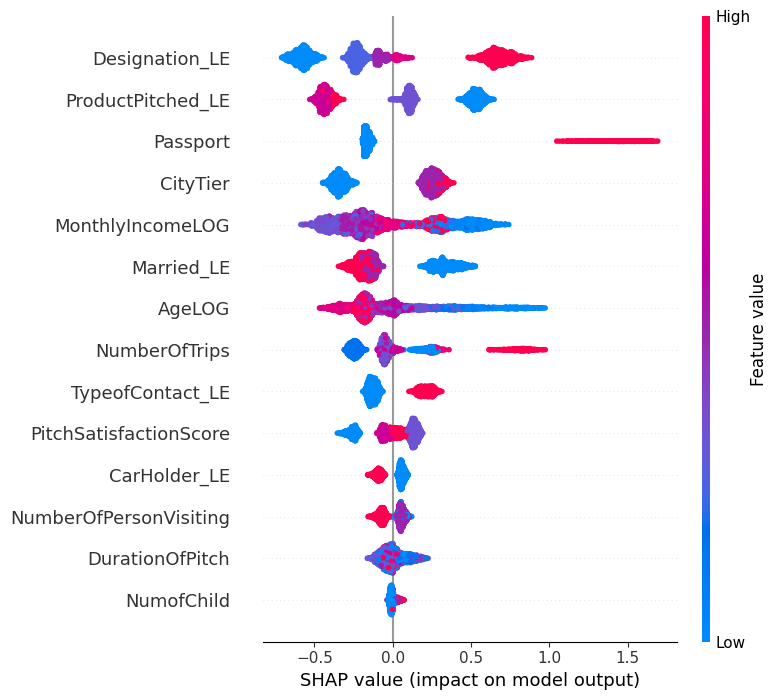

In [ ]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

shap.initjs()
# 基本スコア
explainer = shap.TreeExplainer(model=models[0])

# 学習済みのモデル（例：lgb_model）
# 学習に使った特徴量データ（例：X_train）

# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)

# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])

# ② SHAP値を計算（X_trainは学習に使った特徴量データ）
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))

# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

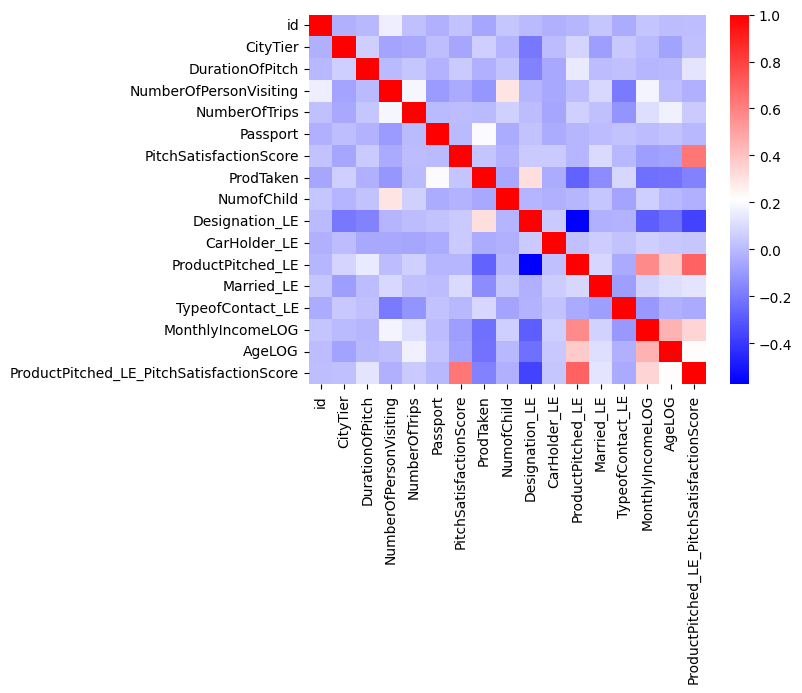

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()

# sns.heatmap(all_df_corr,annot=True,cmap="bwr")
sns.heatmap(all_df_corr,annot=False,cmap="bwr")
plt.show()
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

[I 2025-05-23 10:30:54,435] A new study created in memory with name: no-name-b295ed81-f9f2-460e-ba1a-22ce7e89280c
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.998186	valid's auc: 0.805011
#########################
### Fold 2
#########################
[100]	train's auc: 0.998902	valid's auc: 0.825458
#########################
### Fold 3
#########################
[100]	train's auc: 0.999145	valid's auc: 0.785583


[I 2025-05-23 10:30:55,191] Trial 0 finished with value: 0.8015872642270737 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 28, 'feature_fraction': 0.7928752632738917, 'bagging_fraction': 0.9015054325833236, 'bagging_freq': 6, 'lambda_l1': 1.4942835088265995e-08, 'lambda_l2': 4.999097764234564e-06, 'max_depth': 9}. Best is trial 0 with value: 0.8015872642270737.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.987278	valid's auc: 0.812129
#########################
### Fold 2
#########################
[100]	train's auc: 0.988498	valid's auc: 0.829464
#########################
### Fold 3
#########################


[I 2025-05-23 10:30:55,831] Trial 1 finished with value: 0.8216343515639289 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 22, 'feature_fraction': 0.6030898634035116, 'bagging_fraction': 0.8115395405039862, 'bagging_freq': 1, 'lambda_l1': 1.0819064098889874e-08, 'lambda_l2': 1.6957070639211197e-08, 'max_depth': 6}. Best is trial 1 with value: 0.8216343515639289.


[100]	train's auc: 0.989712	valid's auc: 0.791996
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.99982	valid's auc: 0.795036
#########################
### Fold 2
#########################
[100]	train's auc: 0.999737	valid's auc: 0.815301
#########################
### Fold 3
#########################


[I 2025-05-23 10:30:56,869] Trial 2 finished with value: 0.8069799142448273 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 14, 'feature_fraction': 0.7442016807172265, 'bagging_fraction': 0.6111503676132831, 'bagging_freq': 6, 'lambda_l1': 1.5611898318920095e-05, 'lambda_l2': 0.013132534331446998, 'max_depth': 11}. Best is trial 1 with value: 0.8216343515639289.


[100]	train's auc: 0.99864	valid's auc: 0.76782
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.926932	valid's auc: 0.823742
#########################
### Fold 2
#########################
[100]	train's auc: 0.928322	valid's auc: 0.842739
#########################
### Fold 3
#########################
[100]	train's auc: 0.933752	valid's auc: 0.803243


[I 2025-05-23 10:30:57,702] Trial 3 finished with value: 0.8301251358417887 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 75, 'feature_fraction': 0.5019954416140024, 'bagging_fraction': 0.777628985010166, 'bagging_freq': 4, 'lambda_l1': 1.3298108449059503, 'lambda_l2': 3.102758462782083e-07, 'max_depth': 12}. Best is trial 3 with value: 0.8301251358417887.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.996992	valid's auc: 0.798129
#########################
### Fold 2
#########################
[100]	train's auc: 0.995814	valid's auc: 0.822431
#########################
### Fold 3
#########################
[100]	train's auc: 0.997275	valid's auc: 0.773237


[I 2025-05-23 10:30:58,404] Trial 4 finished with value: 0.8160897201390158 and parameters: {'num_leaves': 250, 'min_data_in_leaf': 23, 'feature_fraction': 0.8103679046874002, 'bagging_fraction': 0.5617456110375273, 'bagging_freq': 2, 'lambda_l1': 0.07229377813466037, 'lambda_l2': 2.7162688522446555e-06, 'max_depth': 11}. Best is trial 3 with value: 0.8301251358417887.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.921499	valid's auc: 0.818933
#########################
### Fold 2
#########################
[100]	train's auc: 0.925132	valid's auc: 0.847645
#########################
### Fold 3
#########################
[100]	train's auc: 0.933545	valid's auc: 0.805101


[I 2025-05-23 10:30:58,920] Trial 5 finished with value: 0.8280545572902657 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 38, 'feature_fraction': 0.544731955095192, 'bagging_fraction': 0.8208361247102827, 'bagging_freq': 4, 'lambda_l1': 0.0013794747159965918, 'lambda_l2': 1.4924966875826364, 'max_depth': 4}. Best is trial 3 with value: 0.8301251358417887.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.908954	valid's auc: 0.821779
#########################
### Fold 2
#########################
[100]	train's auc: 0.910268	valid's auc: 0.841386
#########################
### Fold 3
#########################
[100]	train's auc: 0.92056	valid's auc: 0.806352


[I 2025-05-23 10:31:02,684] Trial 6 finished with value: 0.821126962308611 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 99, 'feature_fraction': 0.5159775851320532, 'bagging_fraction': 0.579700080595271, 'bagging_freq': 3, 'lambda_l1': 8.626765799395585e-06, 'lambda_l2': 0.0345309682420711, 'max_depth': 11}. Best is trial 3 with value: 0.8301251358417887.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.946396	valid's auc: 0.815646
#########################
### Fold 2
#########################
[100]	train's auc: 0.951824	valid's auc: 0.83483
#########################
### Fold 3
#########################
[100]	train's auc: 0.955766	valid's auc: 0.796144


[I 2025-05-23 10:31:03,265] Trial 7 finished with value: 0.8261312527571847 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 25, 'feature_fraction': 0.8295753839831921, 'bagging_fraction': 0.7651688069890838, 'bagging_freq': 1, 'lambda_l1': 0.0001689234079247022, 'lambda_l2': 8.137268765339655e-07, 'max_depth': 4}. Best is trial 3 with value: 0.8301251358417887.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.98306	valid's auc: 0.805918
#########################
### Fold 2
#########################
[100]	train's auc: 0.981654	valid's auc: 0.826637
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:04,029] Trial 8 finished with value: 0.8197312215539225 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 47, 'feature_fraction': 0.6412378062323092, 'bagging_fraction': 0.6891229060223041, 'bagging_freq': 7, 'lambda_l1': 0.0009573362735644148, 'lambda_l2': 1.0087722416469642e-08, 'max_depth': 12}. Best is trial 3 with value: 0.8301251358417887.


[100]	train's auc: 0.982006	valid's auc: 0.788893
#########################
### Fold 1
#########################
[100]	train's auc: 0.894649	valid's auc: 0.819331


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.888128	valid's auc: 0.848624
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:04,579] Trial 9 finished with value: 0.8285784224060943 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 57, 'feature_fraction': 0.9172622655974704, 'bagging_fraction': 0.5529217618310822, 'bagging_freq': 2, 'lambda_l1': 5.579232442948922e-07, 'lambda_l2': 1.4320859205437713, 'max_depth': 3}. Best is trial 3 with value: 0.8301251358417887.


[100]	train's auc: 0.902355	valid's auc: 0.807488
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.884228	valid's auc: 0.821066
[200]	train's auc: 0.890795	valid's auc: 0.822685
#########################
### Fold 2
#########################
[100]	train's auc: 0.886181	valid's auc: 0.850515
#########################
### Fold 3
#########################
[100]	train's auc: 0.893326	valid's auc: 0.804524


[I 2025-05-23 10:31:05,409] Trial 10 finished with value: 0.8242156817912826 and parameters: {'num_leaves': 25, 'min_data_in_leaf': 80, 'feature_fraction': 0.9785491799554547, 'bagging_fraction': 0.9747580752618656, 'bagging_freq': 5, 'lambda_l1': 6.206415841711431, 'lambda_l2': 8.525265925584997e-05, 'max_depth': 8}. Best is trial 3 with value: 0.8301251358417887.


[200]	train's auc: 0.894337	valid's auc: 0.805314
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.919307	valid's auc: 0.820353
#########################
### Fold 2
#########################
[100]	train's auc: 0.926943	valid's auc: 0.84083
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:06,201] Trial 11 finished with value: 0.8225899514735471 and parameters: {'num_leaves': 19, 'min_data_in_leaf': 67, 'feature_fraction': 0.9950421918275689, 'bagging_fraction': 0.6874802953523638, 'bagging_freq': 3, 'lambda_l1': 8.470881690511204e-07, 'lambda_l2': 5.962856073241754, 'max_depth': 6}. Best is trial 3 with value: 0.8301251358417887.


[100]	train's auc: 0.928871	valid's auc: 0.801275
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.882684	valid's auc: 0.824069
#########################
### Fold 2
#########################
[100]	train's auc: 0.880137	valid's auc: 0.849718
#########################
### Fold 3
#########################
[100]	train's auc: 0.894524	valid's auc: 0.816979


[I 2025-05-23 10:31:06,850] Trial 12 finished with value: 0.8306348787914654 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 65, 'feature_fraction': 0.915183919261779, 'bagging_fraction': 0.5136462450821075, 'bagging_freq': 3, 'lambda_l1': 0.7560450234000367, 'lambda_l2': 0.0008962115912066176, 'max_depth': 3}. Best is trial 12 with value: 0.8306348787914654.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.897911	valid's auc: 0.820214
#########################
### Fold 2
#########################
[100]	train's auc: 0.899336	valid's auc: 0.847017
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:07,501] Trial 13 finished with value: 0.8258235912803021 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 81, 'feature_fraction': 0.7063617037054764, 'bagging_fraction': 0.6713157975849728, 'bagging_freq': 4, 'lambda_l1': 2.8735944982358617, 'lambda_l2': 0.000710905826405016, 'max_depth': 6}. Best is trial 12 with value: 0.8306348787914654.


[100]	train's auc: 0.908602	valid's auc: 0.8047
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.928077	valid's auc: 0.81341
#########################
### Fold 2
#########################
[100]	train's auc: 0.928963	valid's auc: 0.839162


[I 2025-05-23 10:31:08,078] Trial 14 finished with value: 0.8220519641915666 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 70, 'feature_fraction': 0.8918302353399479, 'bagging_fraction': 0.5038005768063086, 'bagging_freq': 3, 'lambda_l1': 0.1756426791174202, 'lambda_l2': 0.0004924596373060388, 'max_depth': 9}. Best is trial 12 with value: 0.8306348787914654.


#########################
### Fold 3
#########################
[100]	train's auc: 0.931978	valid's auc: 0.801816


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.940209	valid's auc: 0.818383
#########################
### Fold 2
#########################
[100]	train's auc: 0.93766	valid's auc: 0.844062
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:08,736] Trial 15 finished with value: 0.82758314593443 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 98, 'feature_fraction': 0.6832023545922425, 'bagging_fraction': 0.8481514040976948, 'bagging_freq': 4, 'lambda_l1': 0.03236476489932557, 'lambda_l2': 2.1878377384988573e-07, 'max_depth': 7}. Best is trial 12 with value: 0.8306348787914654.


[100]	train's auc: 0.942378	valid's auc: 0.798488
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.887872	valid's auc: 0.82718
#########################
### Fold 2
#########################
[100]	train's auc: 0.885994	valid's auc: 0.852117
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:09,414] Trial 16 finished with value: 0.8320729860446099 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 86, 'feature_fraction': 0.9000909798923391, 'bagging_fraction': 0.7526362282133754, 'bagging_freq': 5, 'lambda_l1': 0.5540392083311089, 'lambda_l2': 4.398323045397012e-05, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.898556	valid's auc: 0.806546
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.896413	valid's auc: 0.814486
#########################
### Fold 2
#########################
[100]	train's auc: 0.892608	valid's auc: 0.851071


[I 2025-05-23 10:31:09,970] Trial 17 finished with value: 0.8315941773636472 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 59, 'feature_fraction': 0.8803638836584011, 'bagging_fraction': 0.6384337229345436, 'bagging_freq': 5, 'lambda_l1': 0.010633638083245921, 'lambda_l2': 2.799036507117158e-05, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


#########################
### Fold 3
#########################
[100]	train's auc: 0.902409	valid's auc: 0.805963


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.918365	valid's auc: 0.818026
#########################
### Fold 2
#########################
[100]	train's auc: 0.92089	valid's auc: 0.841361
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:10,588] Trial 18 finished with value: 0.8281994776143492 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 85, 'feature_fraction': 0.8567792130399556, 'bagging_fraction': 0.6445387439107968, 'bagging_freq': 5, 'lambda_l1': 0.013617037320467897, 'lambda_l2': 2.6533898370324473e-05, 'max_depth': 5}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.925631	valid's auc: 0.807579
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.926822	valid's auc: 0.82631
#########################
### Fold 2
#########################
[100]	train's auc: 0.926855	valid's auc: 0.840612
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:11,152] Trial 19 finished with value: 0.8272684233744715 and parameters: {'num_leaves': 212, 'min_data_in_leaf': 53, 'feature_fraction': 0.9582327599001603, 'bagging_fraction': 0.7254670039393364, 'bagging_freq': 6, 'lambda_l1': 0.007166527706718746, 'lambda_l2': 2.6527606468349812e-05, 'max_depth': 4}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.931622	valid's auc: 0.801488
#########################
### Fold 1
#########################
[100]	train's auc: 0.892636	valid's auc: 0.821833


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.887847	valid's auc: 0.85028
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:11,729] Trial 20 finished with value: 0.8300390578766719 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 90, 'feature_fraction': 0.863473104599277, 'bagging_fraction': 0.8883633726186277, 'bagging_freq': 5, 'lambda_l1': 0.2546764757847371, 'lambda_l2': 0.003391965072320904, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.900844	valid's auc: 0.79915
#########################
### Fold 1
#########################
[100]	train's auc: 0.88519	valid's auc: 0.816256


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.887321	valid's auc: 0.850207
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:12,308] Trial 21 finished with value: 0.8278971960102863 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 64, 'feature_fraction': 0.9296127054859802, 'bagging_fraction': 0.5164033237789603, 'bagging_freq': 5, 'lambda_l1': 0.601513374693202, 'lambda_l2': 0.00014281892281198052, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.893811	valid's auc: 0.810475
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.861533	valid's auc: 0.81289
[200]	train's auc: 0.863809	valid's auc: 0.815634
#########################
### Fold 2
#########################
[100]	train's auc: 0.852862	valid's auc: 0.85886
#########################
### Fold 3
#########################
[100]	train's auc: 0.864905	valid's auc: 0.801955


[I 2025-05-23 10:31:16,022] Trial 22 finished with value: 0.8219383143782482 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 59, 'feature_fraction': 0.8962904958187682, 'bagging_fraction': 0.625500806840011, 'bagging_freq': 7, 'lambda_l1': 8.902793053121568, 'lambda_l2': 0.002702871509022927, 'max_depth': 5}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.90268	valid's auc: 0.821084
#########################
### Fold 2
#########################
[100]	train's auc: 0.898685	valid's auc: 0.850866
#########################
### Fold 3
#########################
[100]	train's auc: 0.913131	valid's auc: 0.805496


[I 2025-05-23 10:31:16,576] Trial 23 finished with value: 0.8311089800837108 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 47, 'feature_fraction': 0.7814209130146459, 'bagging_fraction': 0.7382549253259105, 'bagging_freq': 3, 'lambda_l1': 0.004193875938870678, 'lambda_l2': 0.07858827790279298, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.949025	valid's auc: 0.816582
#########################
### Fold 2
#########################
[100]	train's auc: 0.953417	valid's auc: 0.832461
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:17,316] Trial 24 finished with value: 0.8236289394118723 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 45, 'feature_fraction': 0.7713523030043306, 'bagging_fraction': 0.7260665721378166, 'bagging_freq': 6, 'lambda_l1': 0.0038712580029909584, 'lambda_l2': 0.032597906892361604, 'max_depth': 5}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.949908	valid's auc: 0.799253
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.936856	valid's auc: 0.817936
#########################
### Fold 2
#########################
[100]	train's auc: 0.933188	valid's auc: 0.84199


[I 2025-05-23 10:31:17,961] Trial 25 finished with value: 0.8269002383283659 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 37, 'feature_fraction': 0.7446548108439974, 'bagging_fraction': 0.7338474123580327, 'bagging_freq': 2, 'lambda_l1': 0.00013828048000642614, 'lambda_l2': 0.16799049902515195, 'max_depth': 4}. Best is trial 16 with value: 0.8320729860446099.


#########################
### Fold 3
#########################
[100]	train's auc: 0.937801	valid's auc: 0.796107


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.906443	valid's auc: 0.824467
[200]	train's auc: 0.936229	valid's auc: 0.815108
#########################
### Fold 2
#########################
[100]	train's auc: 0.899646	valid's auc: 0.846376
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:18,536] Trial 26 finished with value: 0.8279099732082333 and parameters: {'num_leaves': 40, 'min_data_in_leaf': 47, 'feature_fraction': 0.8396064859036039, 'bagging_fraction': 0.7867583398196871, 'bagging_freq': 5, 'lambda_l1': 0.04191069553865129, 'lambda_l2': 1.3333142267071266e-05, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.910552	valid's auc: 0.803383
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.932988	valid's auc: 0.817386
#########################
### Fold 2
#########################
[100]	train's auc: 0.93136	valid's auc: 0.842787
#########################
### Fold 3
#########################
[100]	train's auc: 0.94323	valid's auc: 0.794383


[I 2025-05-23 10:31:19,302] Trial 27 finished with value: 0.8129472019281464 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 35, 'feature_fraction': 0.949508608080646, 'bagging_fraction': 0.6661363845882994, 'bagging_freq': 4, 'lambda_l1': 0.0032491718193661473, 'lambda_l2': 0.0001149144053723656, 'max_depth': 4}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.91191	valid's auc: 0.826069
#########################
### Fold 2
#########################
[100]	train's auc: 0.913948	valid's auc: 0.842274
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:20,083] Trial 28 finished with value: 0.8270273378237338 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 91, 'feature_fraction': 0.872977638084202, 'bagging_fraction': 0.5998192693567322, 'bagging_freq': 5, 'lambda_l1': 0.0005019951547116789, 'lambda_l2': 2.3847452028622928e-06, 'max_depth': 5}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.917867	valid's auc: 0.806461
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.965206	valid's auc: 0.815827
#########################
### Fold 2
#########################
[100]	train's auc: 0.963516	valid's auc: 0.833132
#########################
### Fold 3
#########################
[100]	train's auc: 0.968931	valid's auc: 0.792251


[I 2025-05-23 10:31:20,740] Trial 29 finished with value: 0.8224154418489548 and parameters: {'num_leaves': 43, 'min_data_in_leaf': 74, 'feature_fraction': 0.7967676629253916, 'bagging_fraction': 0.8660108428604322, 'bagging_freq': 6, 'lambda_l1': 4.108305915431482e-05, 'lambda_l2': 0.2382774509818641, 'max_depth': 8}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.901397	valid's auc: 0.828087
[200]	train's auc: 0.928945	valid's auc: 0.825325
#########################
### Fold 2
#########################
[100]	train's auc: 0.892291	valid's auc: 0.85054
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:21,430] Trial 30 finished with value: 0.8279247678584878 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 54, 'feature_fraction': 0.7676012172655995, 'bagging_fraction': 0.7140355126194824, 'bagging_freq': 4, 'lambda_l1': 0.14160307683526072, 'lambda_l2': 6.727882940300058e-06, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.91167	valid's auc: 0.79915
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.885788	valid's auc: 0.824564
#########################
### Fold 2
#########################
[100]	train's auc: 0.884513	valid's auc: 0.84941
#########################
### Fold 3
#########################
[100]	train's auc: 0.896699	valid's auc: 0.808909


[I 2025-05-23 10:31:22,189] Trial 31 finished with value: 0.828476204822518 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 62, 'feature_fraction': 0.9181300661898556, 'bagging_fraction': 0.5314826378816688, 'bagging_freq': 3, 'lambda_l1': 0.6879934291733141, 'lambda_l2': 0.002247240171600655, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.930759	valid's auc: 0.813066
#########################
### Fold 2
#########################
[100]	train's auc: 0.934837	valid's auc: 0.833718
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:22,804] Trial 32 finished with value: 0.8257640764372329 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 49, 'feature_fraction': 0.8215020111150463, 'bagging_fraction': 0.9261775312024677, 'bagging_freq': 3, 'lambda_l1': 0.012076450686439581, 'lambda_l2': 0.0006716968133030156, 'max_depth': 4}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.939511	valid's auc: 0.801749
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.887862	valid's auc: 0.822099
#########################
### Fold 2
#########################
[100]	train's auc: 0.884807	valid's auc: 0.851833
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:23,591] Trial 33 finished with value: 0.8243609383574173 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 70, 'feature_fraction': 0.8877249388136844, 'bagging_fraction': 0.6409456445132966, 'bagging_freq': 2, 'lambda_l1': 1.734750635412379, 'lambda_l2': 0.010166162121672396, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.895377	valid's auc: 0.806291
[200]	train's auc: 0.920734	valid's auc: 0.799314


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.951021	valid's auc: 0.807483
#########################
### Fold 2
#########################
[100]	train's auc: 0.955446	valid's auc: 0.831319
#########################
### Fold 3
#########################
[100]	train's auc: 0.955946	valid's auc: 0.79782


[I 2025-05-23 10:31:24,355] Trial 34 finished with value: 0.8232644530283304 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 41, 'feature_fraction': 0.7040460665393147, 'bagging_fraction': 0.7594574841424827, 'bagging_freq': 3, 'lambda_l1': 0.3871182743077282, 'lambda_l2': 2.883562402172342e-05, 'max_depth': 5}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.930968	valid's auc: 0.81686
#########################
### Fold 2
#########################
[100]	train's auc: 0.931362	valid's auc: 0.840201
#########################
### Fold 3
#########################
[100]	train's auc: 0.937397	valid's auc: 0.799903


[I 2025-05-23 10:31:24,985] Trial 35 finished with value: 0.8265579439202058 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 60, 'feature_fraction': 0.9487225757026483, 'bagging_fraction': 0.8005376595842242, 'bagging_freq': 1, 'lambda_l1': 0.03138267145181586, 'lambda_l2': 1.6647528326849227e-07, 'max_depth': 4}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.997244	valid's auc: 0.807791
#########################
### Fold 2
#########################
[100]	train's auc: 0.997433	valid's auc: 0.822999
#########################
### Fold 3
#########################
[100]	train's auc: 0.997017	valid's auc: 0.79202


[I 2025-05-23 10:31:28,980] Trial 36 finished with value: 0.8086665043738366 and parameters: {'num_leaves': 46, 'min_data_in_leaf': 11, 'feature_fraction': 0.8465599645171629, 'bagging_fraction': 0.5924242681665409, 'bagging_freq': 4, 'lambda_l1': 0.07996546331135684, 'lambda_l2': 0.00023702347082484818, 'max_depth': 7}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.997058	valid's auc: 0.809332
#########################
### Fold 2
#########################
[100]	train's auc: 0.995784	valid's auc: 0.816751
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:29,911] Trial 37 finished with value: 0.8081335607226244 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 30, 'feature_fraction': 0.7858653847997926, 'bagging_fraction': 0.7030922907202923, 'bagging_freq': 2, 'lambda_l1': 0.002739316968370737, 'lambda_l2': 0.15490189744255076, 'max_depth': 10}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.996961	valid's auc: 0.779589
#########################
### Fold 1
#########################
[100]	train's auc: 0.880344	valid's auc: 0.827646


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.900208	valid's auc: 0.821978
#########################
### Fold 2
#########################
[100]	train's auc: 0.873282	valid's auc: 0.854201
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:30,567] Trial 38 finished with value: 0.8303188112633018 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 74, 'feature_fraction': 0.9196838368117686, 'bagging_fraction': 0.5612950605565461, 'bagging_freq': 6, 'lambda_l1': 1.9088558341046291, 'lambda_l2': 1.2337926711529732e-06, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.882975	valid's auc: 0.808684
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.95879	valid's auc: 0.810897
#########################
### Fold 2
#########################
[100]	train's auc: 0.965609	valid's auc: 0.827803
#########################
### Fold 3
#########################
[100]	train's auc: 0.966016	valid's auc: 0.797334


[I 2025-05-23 10:31:31,211] Trial 39 finished with value: 0.8227036012868656 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 51, 'feature_fraction': 0.59595299909485, 'bagging_fraction': 0.81770799643155, 'bagging_freq': 3, 'lambda_l1': 0.017519232538127576, 'lambda_l2': 0.011192953001543703, 'max_depth': 6}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.935379	valid's auc: 0.81599
#########################
### Fold 2
#########################
[100]	train's auc: 0.933956	valid's auc: 0.836558
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:31,880] Trial 40 finished with value: 0.8101358821377462 and parameters: {'num_leaves': 256, 'min_data_in_leaf': 32, 'feature_fraction': 0.8132226531137006, 'bagging_fraction': 0.7455949090249344, 'bagging_freq': 4, 'lambda_l1': 0.0011873693948457797, 'lambda_l2': 6.027302049156834e-05, 'max_depth': 4}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.944446	valid's auc: 0.804148
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.872898	valid's auc: 0.826933
[200]	train's auc: 0.888852	valid's auc: 0.824014
#########################
### Fold 2
#########################
[100]	train's auc: 0.863196	valid's auc: 0.85121
#########################
### Fold 3
#########################
[100]	train's auc: 0.875764	valid's auc: 0.806492


[I 2025-05-23 10:31:32,566] Trial 41 finished with value: 0.8278067468985033 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 79, 'feature_fraction': 0.9134208098206098, 'bagging_fraction': 0.5540811277697222, 'bagging_freq': 6, 'lambda_l1': 3.3008616484134485, 'lambda_l2': 6.119224594092673e-08, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.882297	valid's auc: 0.822854
[200]	train's auc: 0.910669	valid's auc: 0.815162
#########################
### Fold 2
#########################
[100]	train's auc: 0.876717	valid's auc: 0.857839
[200]	train's auc: 0.898768	valid's auc: 0.853549
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:33,311] Trial 42 finished with value: 0.8296382573515961 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 75, 'feature_fraction': 0.969236634513019, 'bagging_fraction': 0.5765503295780882, 'bagging_freq': 7, 'lambda_l1': 0.9887890619654673, 'lambda_l2': 9.224577691588321e-07, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.888802	valid's auc: 0.803625
[200]	train's auc: 0.915433	valid's auc: 0.806589


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.90682	valid's auc: 0.813464
#########################
### Fold 2
#########################


[I 2025-05-23 10:31:33,855] Trial 43 finished with value: 0.8261531084905153 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 65, 'feature_fraction': 0.8783594220291566, 'bagging_fraction': 0.5372928346630638, 'bagging_freq': 5, 'lambda_l1': 0.09094312891413638, 'lambda_l2': 3.2805733505816703e-06, 'max_depth': 4}. Best is trial 16 with value: 0.8320729860446099.


[100]	train's auc: 0.909117	valid's auc: 0.838395
#########################
### Fold 3
#########################
[100]	train's auc: 0.912338	valid's auc: 0.797984


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.875015	valid's auc: 0.822655
#########################
### Fold 2
#########################
[100]	train's auc: 0.867394	valid's auc: 0.851367
#########################
### Fold 3
#########################
[100]	train's auc: 0.877614	valid's auc: 0.803741


[I 2025-05-23 10:31:34,407] Trial 44 finished with value: 0.8272334542011427 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 86, 'feature_fraction': 0.9992241927083311, 'bagging_fraction': 0.5710192214584281, 'bagging_freq': 6, 'lambda_l1': 2.506341792556025, 'lambda_l2': 1.099827801708296e-06, 'max_depth': 3}. Best is trial 16 with value: 0.8320729860446099.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.907283	valid's auc: 0.832371
[200]	train's auc: 0.939492	valid's auc: 0.820214
#########################
### Fold 2
#########################
[100]	train's auc: 0.908066	valid's auc: 0.844346
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:35,084] Trial 45 finished with value: 0.8322616178353542 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 71, 'feature_fraction': 0.9341850265806821, 'bagging_fraction': 0.6178555950161336, 'bagging_freq': 6, 'lambda_l1': 0.3146501801402528, 'lambda_l2': 7.229882468339914e-06, 'max_depth': 4}. Best is trial 45 with value: 0.8322616178353542.


[100]	train's auc: 0.913277	valid's auc: 0.806358
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.911003	valid's auc: 0.824461
#########################
### Fold 2
#########################
[100]	train's auc: 0.910895	valid's auc: 0.841796
#########################
### Fold 3
#########################
[100]	train's auc: 0.914805	valid's auc: 0.80037


[I 2025-05-23 10:31:35,737] Trial 46 finished with value: 0.8272912878339554 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 70, 'feature_fraction': 0.9388179282236351, 'bagging_fraction': 0.6124208003183419, 'bagging_freq': 5, 'lambda_l1': 3.732875288309584e-08, 'lambda_l2': 1.3108420937981915e-05, 'max_depth': 4}. Best is trial 45 with value: 0.8322616178353542.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.938185	valid's auc: 0.817271
#########################
### Fold 2
#########################
[100]	train's auc: 0.942742	valid's auc: 0.839247
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:36,395] Trial 47 finished with value: 0.8257523079654396 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 57, 'feature_fraction': 0.9783473643529245, 'bagging_fraction': 0.6799822239525164, 'bagging_freq': 3, 'lambda_l1': 0.2697913122926347, 'lambda_l2': 0.0013082386965489253, 'max_depth': 5}. Best is trial 45 with value: 0.8322616178353542.


[100]	train's auc: 0.948312	valid's auc: 0.795937
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.923979	valid's auc: 0.811017
#########################
### Fold 2
#########################
[100]	train's auc: 0.924653	valid's auc: 0.839174
#########################
### Fold 3
#########################
[100]	train's auc: 0.934755	valid's auc: 0.791765


[I 2025-05-23 10:31:37,020] Trial 48 finished with value: 0.8248387383122263 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 42, 'feature_fraction': 0.900539159797172, 'bagging_fraction': 0.6506177540879807, 'bagging_freq': 4, 'lambda_l1': 0.04439678452836288, 'lambda_l2': 0.8201930705143418, 'max_depth': 4}. Best is trial 45 with value: 0.8322616178353542.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.887101	valid's auc: 0.819773
#########################
### Fold 2
#########################
[100]	train's auc: 0.890094	valid's auc: 0.845778
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:37,700] Trial 49 finished with value: 0.830419347636622 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 93, 'feature_fraction': 0.8359578280519963, 'bagging_fraction': 0.7728683852531713, 'bagging_freq': 7, 'lambda_l1': 0.006570735065457905, 'lambda_l2': 0.048458600740018926, 'max_depth': 3}. Best is trial 45 with value: 0.8322616178353542.


[100]	train's auc: 0.898794	valid's auc: 0.805423
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.919114	valid's auc: 0.821295
#########################
### Fold 2
#########################
[100]	train's auc: 0.916684	valid's auc: 0.843325


[I 2025-05-23 10:31:38,309] Trial 50 finished with value: 0.8292794870829253 and parameters: {'num_leaves': 224, 'min_data_in_leaf': 84, 'feature_fraction': 0.8617074446831874, 'bagging_fraction': 0.8387582716917479, 'bagging_freq': 5, 'lambda_l1': 0.00030973459973920544, 'lambda_l2': 0.00027536607484588517, 'max_depth': 4}. Best is trial 45 with value: 0.8322616178353542.


#########################
### Fold 3
#########################
[100]	train's auc: 0.925764	valid's auc: 0.799672


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886343	valid's auc: 0.821833
#########################
### Fold 2
#########################
[100]	train's auc: 0.887076	valid's auc: 0.845458
#########################
### Fold 3
#########################
[100]	train's auc: 0.898421	valid's auc: 0.803492


[I 2025-05-23 10:31:40,770] Trial 51 finished with value: 0.8293928006541926 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 95, 'feature_fraction': 0.8222693348457092, 'bagging_fraction': 0.7795527459698768, 'bagging_freq': 7, 'lambda_l1': 0.0016144485106688107, 'lambda_l2': 0.06451922442916252, 'max_depth': 3}. Best is trial 45 with value: 0.8322616178353542.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886968	valid's auc: 0.82425
#########################
### Fold 2
#########################
[100]	train's auc: 0.886567	valid's auc: 0.84602
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:42,588] Trial 52 finished with value: 0.830583433757626 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 91, 'feature_fraction': 0.7219949415537702, 'bagging_fraction': 0.7517910557884074, 'bagging_freq': 7, 'lambda_l1': 0.0065228262871405195, 'lambda_l2': 0.006254054367841388, 'max_depth': 3}. Best is trial 45 with value: 0.8322616178353542.


[100]	train's auc: 0.895751	valid's auc: 0.808866
#########################
### Fold 1
#########################
[100]	train's auc: 0.882622	valid's auc: 0.822359


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.880596	valid's auc: 0.853609
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:43,128] Trial 53 finished with value: 0.8331973794639495 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 100, 'feature_fraction': 0.670751230136397, 'bagging_fraction': 0.7078553831859342, 'bagging_freq': 6, 'lambda_l1': 0.1365241934892181, 'lambda_l2': 0.0063075352882038535, 'max_depth': 3}. Best is trial 53 with value: 0.8331973794639495.


[100]	train's auc: 0.894096	valid's auc: 0.806291
#########################
### Fold 1
#########################
[100]	train's auc: 0.881636	valid's auc: 0.824419


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.882103	valid's auc: 0.853464
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:43,650] Trial 54 finished with value: 0.8321005578928113 and parameters: {'num_leaves': 208, 'min_data_in_leaf': 99, 'feature_fraction': 0.632556220703749, 'bagging_fraction': 0.6968841504487653, 'bagging_freq': 6, 'lambda_l1': 0.17405353578275637, 'lambda_l2': 0.0011532654426631723, 'max_depth': 3}. Best is trial 53 with value: 0.8331973794639495.


[100]	train's auc: 0.892495	valid's auc: 0.812048
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.882012	valid's auc: 0.825984
#########################
### Fold 2
#########################
[100]	train's auc: 0.880126	valid's auc: 0.853011
#########################
### Fold 3
#########################
[100]	train's auc: 0.892284	valid's auc: 0.81302


[I 2025-05-23 10:31:44,321] Trial 55 finished with value: 0.8301597687730662 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 96, 'feature_fraction': 0.6472733437613111, 'bagging_fraction': 0.6947828520719788, 'bagging_freq': 6, 'lambda_l1': 0.14366733679369928, 'lambda_l2': 5.158848703094287e-05, 'max_depth': 3}. Best is trial 53 with value: 0.8331973794639495.


[200]	train's auc: 0.916075	valid's auc: 0.806911
#########################
### Fold 1
#########################
[100]	train's auc: 0.900976	valid's auc: 0.822788


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.89684	valid's auc: 0.844074
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:44,843] Trial 56 finished with value: 0.829889766405922 and parameters: {'num_leaves': 222, 'min_data_in_leaf': 99, 'feature_fraction': 0.6128031486320533, 'bagging_fraction': 0.6623515299479814, 'bagging_freq': 6, 'lambda_l1': 0.024622107606666607, 'lambda_l2': 0.022580952549413863, 'max_depth': 4}. Best is trial 53 with value: 0.8331973794639495.


[100]	train's auc: 0.902846	valid's auc: 0.809067
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.908027	valid's auc: 0.818467
#########################
### Fold 2
#########################
[100]	train's auc: 0.910155	valid's auc: 0.844552
#########################
### Fold 3
#########################
[100]	train's auc: 0.915119	valid's auc: 0.813026


[I 2025-05-23 10:31:45,570] Trial 57 finished with value: 0.8283090925230527 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 88, 'feature_fraction': 0.5479286193511225, 'bagging_fraction': 0.6270633518221421, 'bagging_freq': 6, 'lambda_l1': 0.36215037443783454, 'lambda_l2': 1.046086316395077e-05, 'max_depth': 5}. Best is trial 53 with value: 0.8331973794639495.


[200]	train's auc: 0.94843	valid's auc: 0.803474
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.945318	valid's auc: 0.81486
#########################
### Fold 2
#########################
[100]	train's auc: 0.946991	valid's auc: 0.834111
#########################
### Fold 3
#########################
[100]	train's auc: 0.948892	valid's auc: 0.794954


[I 2025-05-23 10:31:46,247] Trial 58 finished with value: 0.8273652610852279 and parameters: {'num_leaves': 236, 'min_data_in_leaf': 81, 'feature_fraction': 0.640136845921076, 'bagging_fraction': 0.7064507748546662, 'bagging_freq': 5, 'lambda_l1': 0.05822498810258953, 'lambda_l2': 0.005480960854837408, 'max_depth': 12}. Best is trial 53 with value: 0.8331973794639495.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.903142	valid's auc: 0.820316
#########################
### Fold 2
#########################
[100]	train's auc: 0.902846	valid's auc: 0.846612
#########################
### Fold 3
#########################
[100]	train's auc: 0.907989	valid's auc: 0.81186


[I 2025-05-23 10:31:46,841] Trial 59 finished with value: 0.8291950903280646 and parameters: {'num_leaves': 206, 'min_data_in_leaf': 96, 'feature_fraction': 0.6635580216736042, 'bagging_fraction': 0.7351807021666614, 'bagging_freq': 6, 'lambda_l1': 0.14014797325883838, 'lambda_l2': 0.00138071444863187, 'max_depth': 4}. Best is trial 53 with value: 0.8331973794639495.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.865594	valid's auc: 0.823803
[200]	train's auc: 0.873162	valid's auc: 0.824993
#########################
### Fold 2
#########################
[100]	train's auc: 0.856904	valid's auc: 0.854171
[200]	train's auc: 0.872444	valid's auc: 0.853984
#########################
### Fold 3
#########################
[100]	train's auc: 0.868857	valid's auc: 0.809473


[I 2025-05-23 10:31:47,753] Trial 60 finished with value: 0.8300908391525624 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 100, 'feature_fraction': 0.6104361901425109, 'bagging_fraction': 0.6787636794696199, 'bagging_freq': 5, 'lambda_l1': 5.583748804516758, 'lambda_l2': 0.0003881032991015012, 'max_depth': 3}. Best is trial 53 with value: 0.8331973794639495.


[200]	train's auc: 0.882687	valid's auc: 0.809753
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.889138	valid's auc: 0.822431
#########################
### Fold 2
#########################
[100]	train's auc: 0.885633	valid's auc: 0.852026
#########################
### Fold 3
#########################
[100]	train's auc: 0.897374	valid's auc: 0.807785


[I 2025-05-23 10:31:48,363] Trial 61 finished with value: 0.8317589359687537 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 77, 'feature_fraction': 0.7262678588200502, 'bagging_fraction': 0.7156118772819468, 'bagging_freq': 6, 'lambda_l1': 0.8208106680661582, 'lambda_l2': 0.00013285658174085947, 'max_depth': 3}. Best is trial 53 with value: 0.8331973794639495.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.890404	valid's auc: 0.81993
#########################
### Fold 2
#########################
[100]	train's auc: 0.885546	valid's auc: 0.85312
#########################
### Fold 3
#########################
[100]	train's auc: 0.896797	valid's auc: 0.808198


[I 2025-05-23 10:31:48,911] Trial 62 finished with value: 0.8307818165678563 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 77, 'feature_fraction': 0.6820451787807855, 'bagging_fraction': 0.7205708064135441, 'bagging_freq': 6, 'lambda_l1': 0.5405646488467246, 'lambda_l2': 0.00017209307732148408, 'max_depth': 3}. Best is trial 53 with value: 0.8331973794639495.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.906729	valid's auc: 0.818751
#########################
### Fold 2
#########################
[100]	train's auc: 0.909999	valid's auc: 0.845482
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:49,580] Trial 63 finished with value: 0.828989310192707 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 69, 'feature_fraction': 0.7158087330209408, 'bagging_fraction': 0.6512371844068484, 'bagging_freq': 6, 'lambda_l1': 0.96726921892382, 'lambda_l2': 3.6619149776598414e-05, 'max_depth': 4}. Best is trial 53 with value: 0.8331973794639495.


[100]	train's auc: 0.912993	valid's auc: 0.804712
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.88735	valid's auc: 0.82286
#########################
### Fold 2
#########################
[100]	train's auc: 0.884563	valid's auc: 0.847077
#########################
### Fold 3
#########################
[100]	train's auc: 0.894791	valid's auc: 0.805344


[I 2025-05-23 10:31:50,251] Trial 64 finished with value: 0.8324310838291782 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 84, 'feature_fraction': 0.728762354745762, 'bagging_fraction': 0.6940769787397759, 'bagging_freq': 7, 'lambda_l1': 0.08257889924985777, 'lambda_l2': 0.00010075912804330137, 'max_depth': 3}. Best is trial 53 with value: 0.8331973794639495.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.882451	valid's auc: 0.823634
#########################
### Fold 2
#########################


[I 2025-05-23 10:31:50,761] Trial 65 finished with value: 0.8352837613918808 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 84, 'feature_fraction': 0.6877686207620288, 'bagging_fraction': 0.6277957401741642, 'bagging_freq': 7, 'lambda_l1': 0.21019764697519355, 'lambda_l2': 5.760575622602168e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.885775	valid's auc: 0.85524
#########################
### Fold 3
#########################
[100]	train's auc: 0.890977	valid's auc: 0.808648


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.871214	valid's auc: 0.82509
#########################
### Fold 2
#########################
[100]	train's auc: 0.8687	valid's auc: 0.851899
#########################
### Fold 3
#########################
[100]	train's auc: 0.878205	valid's auc: 0.808678


[I 2025-05-23 10:31:51,366] Trial 66 finished with value: 0.8296100130192924 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 83, 'feature_fraction': 0.7308775452588073, 'bagging_fraction': 0.6958011838635411, 'bagging_freq': 7, 'lambda_l1': 4.570273072768534, 'lambda_l2': 9.449036248693753e-05, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.898156	valid's auc: 0.818383
#########################
### Fold 2
#########################
[100]	train's auc: 0.901096	valid's auc: 0.846654
#########################
### Fold 3
#########################
[100]	train's auc: 0.903524	valid's auc: 0.811988


[I 2025-05-23 10:31:51,930] Trial 67 finished with value: 0.8313453582457311 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 89, 'feature_fraction': 0.6960258339031654, 'bagging_fraction': 0.6275806378081876, 'bagging_freq': 7, 'lambda_l1': 0.24109827349799512, 'lambda_l2': 5.084809205108846e-06, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.943222	valid's auc: 0.816256
#########################
### Fold 2
#########################
[100]	train's auc: 0.946605	valid's auc: 0.836431
#########################
### Fold 3
#########################
[100]	train's auc: 0.946561	valid's auc: 0.800978


[I 2025-05-23 10:31:55,751] Trial 68 finished with value: 0.8257882858649221 and parameters: {'num_leaves': 204, 'min_data_in_leaf': 78, 'feature_fraction': 0.7595594504358323, 'bagging_fraction': 0.6591194465685202, 'bagging_freq': 7, 'lambda_l1': 2.1561753201861296e-06, 'lambda_l2': 2.1206293111486136e-05, 'max_depth': 10}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886565	valid's auc: 0.824794
#########################
### Fold 2
#########################
[100]	train's auc: 0.884572	valid's auc: 0.84979
#########################
### Fold 3
#########################
[100]	train's auc: 0.894248	valid's auc: 0.805465


[I 2025-05-23 10:31:56,488] Trial 69 finished with value: 0.8302098688387007 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 87, 'feature_fraction': 0.6667351691265458, 'bagging_fraction': 0.797402160701712, 'bagging_freq': 7, 'lambda_l1': 1.2011862060303797, 'lambda_l2': 4.554295505071349e-07, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.917552	valid's auc: 0.822226
#########################
### Fold 2
#########################
[100]	train's auc: 0.923872	valid's auc: 0.839549
#########################
### Fold 3
#########################
[100]	train's auc: 0.922149	valid's auc: 0.802302


[I 2025-05-23 10:31:57,123] Trial 70 finished with value: 0.8278339825046536 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 83, 'feature_fraction': 0.7364066820421049, 'bagging_fraction': 0.6022707265389102, 'bagging_freq': 6, 'lambda_l1': 0.11434330011052297, 'lambda_l2': 0.00048510439870461526, 'max_depth': 6}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.880503	valid's auc: 0.826806
#########################
### Fold 2
#########################
[100]	train's auc: 0.875373	valid's auc: 0.853367
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:57,839] Trial 71 finished with value: 0.8322041204445927 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 93, 'feature_fraction': 0.6272375333749726, 'bagging_fraction': 0.6335842137522003, 'bagging_freq': 6, 'lambda_l1': 0.586886140987925, 'lambda_l2': 9.048413843780127e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.886696	valid's auc: 0.814228
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.879433	valid's auc: 0.824099
#########################
### Fold 2
#########################
[100]	train's auc: 0.879254	valid's auc: 0.852256
#########################
### Fold 3
#########################
[100]	train's auc: 0.892229	valid's auc: 0.814605


[I 2025-05-23 10:31:58,453] Trial 72 finished with value: 0.8300276256469299 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 93, 'feature_fraction': 0.5906475894567681, 'bagging_fraction': 0.6821763525574859, 'bagging_freq': 6, 'lambda_l1': 0.6778528430912948, 'lambda_l2': 9.06490369361172e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[200]	train's auc: 0.913802	valid's auc: 0.806121
#########################
### Fold 1
#########################
[100]	train's auc: 0.878064	valid's auc: 0.822703


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.881589	valid's auc: 0.855929
#########################
### Fold 3
#########################


[I 2025-05-23 10:31:59,007] Trial 73 finished with value: 0.823865990057995 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 94, 'feature_fraction': 0.6302286306794637, 'bagging_fraction': 0.6147410730717608, 'bagging_freq': 7, 'lambda_l1': 0.4023072705999886, 'lambda_l2': 3.425494502842127e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.885427	valid's auc: 0.809364
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.896733	valid's auc: 0.821785
#########################
### Fold 2
#########################
[100]	train's auc: 0.900146	valid's auc: 0.847307
#########################
### Fold 3
#########################
[100]	train's auc: 0.906685	valid's auc: 0.808733


[I 2025-05-23 10:31:59,644] Trial 74 finished with value: 0.8284610739302124 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 97, 'feature_fraction': 0.5617478028084967, 'bagging_fraction': 0.7195334885496948, 'bagging_freq': 6, 'lambda_l1': 0.21723353217493033, 'lambda_l2': 1.7603649937869932e-05, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.881613	valid's auc: 0.825839
#########################
### Fold 2
#########################


[I 2025-05-23 10:32:00,191] Trial 75 finished with value: 0.8312807997718934 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 91, 'feature_fraction': 0.6567348146983791, 'bagging_fraction': 0.7645075627445842, 'bagging_freq': 7, 'lambda_l1': 1.4329975283308733, 'lambda_l2': 7.147535047811485e-05, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.881922	valid's auc: 0.847204
#########################
### Fold 3
#########################
[100]	train's auc: 0.890439	valid's auc: 0.806953


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.862354	valid's auc: 0.82376
[200]	train's auc: 0.867556	valid's auc: 0.82344
#########################
### Fold 2
#########################
[100]	train's auc: 0.849968	valid's auc: 0.858104
[200]	train's auc: 0.854199	valid's auc: 0.858775
#########################
### Fold 3
#########################
[100]	train's auc: 0.869417	valid's auc: 0.810901


[I 2025-05-23 10:32:00,889] Trial 76 finished with value: 0.830502735665329 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 20, 'feature_fraction': 0.6220754125913327, 'bagging_fraction': 0.7103268526071225, 'bagging_freq': 6, 'lambda_l1': 8.722562573048004, 'lambda_l2': 1.8748445698343525e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.909087	valid's auc: 0.821156
#########################
### Fold 2
#########################
[100]	train's auc: 0.912138	valid's auc: 0.843386
#########################
### Fold 3
#########################
[100]	train's auc: 0.914374	valid's auc: 0.807725


[I 2025-05-23 10:32:01,546] Trial 77 finished with value: 0.828117434553847 and parameters: {'num_leaves': 214, 'min_data_in_leaf': 100, 'feature_fraction': 0.6897550151607652, 'bagging_fraction': 0.5904288969944084, 'bagging_freq': 6, 'lambda_l1': 0.06304709195726119, 'lambda_l2': 0.00014674850348880676, 'max_depth': 7}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.8898	valid's auc: 0.821936
#########################
### Fold 2
#########################
[100]	train's auc: 0.890124	valid's auc: 0.844781
#########################
### Fold 3
#########################
[100]	train's auc: 0.896701	valid's auc: 0.805484


[I 2025-05-23 10:32:02,160] Trial 78 finished with value: 0.8287061943855647 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 86, 'feature_fraction': 0.6827501625087438, 'bagging_fraction': 0.7410934408506427, 'bagging_freq': 7, 'lambda_l1': 2.8804713718075456, 'lambda_l2': 4.612777975749478e-05, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.887279	valid's auc: 0.823754
#########################
### Fold 2
#########################
[100]	train's auc: 0.883824	valid's auc: 0.851857
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:02,796] Trial 79 finished with value: 0.8309785181678304 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 73, 'feature_fraction': 0.5842963309701442, 'bagging_fraction': 0.6360418593074568, 'bagging_freq': 6, 'lambda_l1': 0.43973260501938155, 'lambda_l2': 0.0011468204344348108, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.892716	valid's auc: 0.809255
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.883755	valid's auc: 0.820292
#########################
### Fold 2
#########################
[100]	train's auc: 0.88146	valid's auc: 0.853246
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:03,363] Trial 80 finished with value: 0.8339166012115473 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 90, 'feature_fraction': 0.751905116138127, 'bagging_fraction': 0.6669821500991377, 'bagging_freq': 7, 'lambda_l1': 0.024313208227841564, 'lambda_l2': 6.25280151753658e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.893885	valid's auc: 0.81036
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.88491	valid's auc: 0.824105
#########################
### Fold 2
#########################
[100]	train's auc: 0.886211	valid's auc: 0.848697


[I 2025-05-23 10:32:03,920] Trial 81 finished with value: 0.8314021831523903 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 81, 'feature_fraction': 0.672694623831672, 'bagging_fraction': 0.6717983935949989, 'bagging_freq': 7, 'lambda_l1': 0.020040558755170614, 'lambda_l2': 6.196706755913862e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


#########################
### Fold 3
#########################
[100]	train's auc: 0.897486	valid's auc: 0.806382


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.885861	valid's auc: 0.824788
#########################
### Fold 2
#########################


[I 2025-05-23 10:32:04,439] Trial 82 finished with value: 0.8276567829436512 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 89, 'feature_fraction': 0.701526478996452, 'bagging_fraction': 0.6933658356449105, 'bagging_freq': 7, 'lambda_l1': 0.09131969279272799, 'lambda_l2': 5.623405998644672e-07, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.883482	valid's auc: 0.85031
#########################
### Fold 3
#########################
[100]	train's auc: 0.893356	valid's auc: 0.807275


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.902118	valid's auc: 0.826739
[200]	train's auc: 0.929623	valid's auc: 0.818715
#########################
### Fold 2
#########################
[100]	train's auc: 0.901271	valid's auc: 0.848038
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:05,074] Trial 83 finished with value: 0.829873963029514 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 91, 'feature_fraction': 0.7499452102760176, 'bagging_fraction': 0.6665271807080477, 'bagging_freq': 6, 'lambda_l1': 0.2077143455293451, 'lambda_l2': 1.6458345869367908e-06, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.909699	valid's auc: 0.811605
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.884916	valid's auc: 0.822546
#########################
### Fold 2
#########################
[100]	train's auc: 0.884957	valid's auc: 0.851772
#########################
### Fold 3
#########################
[100]	train's auc: 0.894693	valid's auc: 0.80804


[I 2025-05-23 10:32:08,647] Trial 84 finished with value: 0.8320702961082 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 84, 'feature_fraction': 0.798523069091603, 'bagging_fraction': 0.6562909130948558, 'bagging_freq': 7, 'lambda_l1': 0.035095185560610004, 'lambda_l2': 3.3498902662358656e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.895349	valid's auc: 0.828135
#########################
### Fold 2
#########################
[100]	train's auc: 0.900585	valid's auc: 0.84837
#########################
### Fold 3
#########################
[100]	train's auc: 0.90145	valid's auc: 0.807026


[I 2025-05-23 10:32:09,342] Trial 85 finished with value: 0.8303329334294538 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 98, 'feature_fraction': 0.7104167363834896, 'bagging_fraction': 0.6422748421535021, 'bagging_freq': 7, 'lambda_l1': 0.03927920364604185, 'lambda_l2': 3.903671910954323e-06, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.884191	valid's auc: 0.825404
[200]	train's auc: 0.912153	valid's auc: 0.825138
#########################
### Fold 2
#########################
[100]	train's auc: 0.881904	valid's auc: 0.853808
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:10,024] Trial 86 finished with value: 0.8333618018270048 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 84, 'feature_fraction': 0.7627949682954331, 'bagging_fraction': 0.6230593262747294, 'bagging_freq': 7, 'lambda_l1': 0.01236937933042989, 'lambda_l2': 1.492217078756669e-05, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.892432	valid's auc: 0.803953
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.893904	valid's auc: 0.822063
[200]	train's auc: 0.925996	valid's auc: 0.818649
#########################
### Fold 2
#########################


[I 2025-05-23 10:32:10,646] Trial 87 finished with value: 0.8283850832266324 and parameters: {'num_leaves': 33, 'min_data_in_leaf': 93, 'feature_fraction': 0.6482217990118082, 'bagging_fraction': 0.6170444071668094, 'bagging_freq': 7, 'lambda_l1': 0.01473429908140511, 'lambda_l2': 1.6388280322376148e-05, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.900876	valid's auc: 0.846503
#########################
### Fold 3
#########################
[100]	train's auc: 0.89998	valid's auc: 0.808642


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.877718	valid's auc: 0.819839
#########################
### Fold 2
#########################
[100]	train's auc: 0.875529	valid's auc: 0.858207
#########################
### Fold 3
#########################
[100]	train's auc: 0.886782	valid's auc: 0.806674


[I 2025-05-23 10:32:11,239] Trial 88 finished with value: 0.8264150410484296 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 88, 'feature_fraction': 0.5773783139299137, 'bagging_fraction': 0.5860585144298929, 'bagging_freq': 7, 'lambda_l1': 0.06630360477276534, 'lambda_l2': 3.186295711606791e-05, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.965436	valid's auc: 0.819652
#########################
### Fold 2
#########################
[100]	train's auc: 0.965806	valid's auc: 0.837289
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:11,930] Trial 89 finished with value: 0.8252237354608937 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 94, 'feature_fraction': 0.7698205727446242, 'bagging_fraction': 0.9933690243079388, 'bagging_freq': 7, 'lambda_l1': 0.008566180485286163, 'lambda_l2': 8.583148439949803e-06, 'max_depth': 9}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.962289	valid's auc: 0.797947
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.879474	valid's auc: 0.823156
#########################
### Fold 2
#########################
[100]	train's auc: 0.880609	valid's auc: 0.849833
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:12,534] Trial 90 finished with value: 0.8270064908165571 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 86, 'feature_fraction': 0.759249148045978, 'bagging_fraction': 0.6091617166595328, 'bagging_freq': 5, 'lambda_l1': 0.32969776526096023, 'lambda_l2': 0.002290056097201433, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.887829	valid's auc: 0.805708
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.883955	valid's auc: 0.825114
#########################
### Fold 2
#########################
[100]	train's auc: 0.887689	valid's auc: 0.849065
#########################
### Fold 3
#########################
[100]	train's auc: 0.894754	valid's auc: 0.809328


[I 2025-05-23 10:32:13,138] Trial 91 finished with value: 0.8327353828855486 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 83, 'feature_fraction': 0.7939495521642269, 'bagging_fraction': 0.6577999057259475, 'bagging_freq': 7, 'lambda_l1': 0.03387404158442147, 'lambda_l2': 2.6208346008073394e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.883494	valid's auc: 0.824069
#########################
### Fold 2
#########################
[100]	train's auc: 0.882113	valid's auc: 0.856346
#########################
### Fold 3
#########################
[100]	train's auc: 0.891599	valid's auc: 0.804378


[I 2025-05-23 10:32:13,696] Trial 92 finished with value: 0.8339324045879555 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 82, 'feature_fraction': 0.7405419808632228, 'bagging_fraction': 0.6323541670154665, 'bagging_freq': 7, 'lambda_l1': 0.16663199536254245, 'lambda_l2': 6.794686929904012e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.
<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886447	valid's auc: 0.822171
#########################
### Fold 2
#########################
[100]	train's auc: 0.887674	valid's auc: 0.852546
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:14,364] Trial 93 finished with value: 0.8313914234067507 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 80, 'feature_fraction': 0.780701585266176, 'bagging_fraction': 0.6304941828515656, 'bagging_freq': 7, 'lambda_l1': 0.11024905112864052, 'lambda_l2': 2.0720019284095222e-06, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.894486	valid's auc: 0.803237
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.885593	valid's auc: 0.824479
#########################
### Fold 2
#########################
[100]	train's auc: 0.887492	valid's auc: 0.850848
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:14,885] Trial 94 finished with value: 0.828862210697339 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 83, 'feature_fraction': 0.7382960630581127, 'bagging_fraction': 0.6464028027761428, 'bagging_freq': 7, 'lambda_l1': 0.15127358237356361, 'lambda_l2': 1.6841278714278536e-07, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.89319	valid's auc: 0.802405
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.9132	valid's auc: 0.823102
#########################
### Fold 2
#########################
[100]	train's auc: 0.915761	valid's auc: 0.838201
#########################
### Fold 3
#########################


[I 2025-05-23 10:32:15,645] Trial 95 finished with value: 0.8287919361086303 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 72, 'feature_fraction': 0.8035085478961029, 'bagging_fraction': 0.6697880786513419, 'bagging_freq': 7, 'lambda_l1': 0.055387054892310515, 'lambda_l2': 5.000367153348004e-06, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.917101	valid's auc: 0.802733
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.882776	valid's auc: 0.827331
#########################
### Fold 2
#########################
[100]	train's auc: 0.877968	valid's auc: 0.854231


[I 2025-05-23 10:32:16,171] Trial 96 finished with value: 0.8336835854700395 and parameters: {'num_leaves': 49, 'min_data_in_leaf': 92, 'feature_fraction': 0.750832853267395, 'bagging_fraction': 0.6197395462676234, 'bagging_freq': 7, 'lambda_l1': 0.027097300531106514, 'lambda_l2': 1.13162099856547e-05, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


#########################
### Fold 3
#########################
[100]	train's auc: 0.887453	valid's auc: 0.806844


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.884214	valid's auc: 0.820044
#########################
### Fold 2
#########################


[I 2025-05-23 10:32:16,650] Trial 97 finished with value: 0.8251840588988475 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 76, 'feature_fraction': 0.7515872870655759, 'bagging_fraction': 0.6021147877002936, 'bagging_freq': 7, 'lambda_l1': 0.017086494180367364, 'lambda_l2': 6.570780731278864e-07, 'max_depth': 3}. Best is trial 65 with value: 0.8352837613918808.


[100]	train's auc: 0.886847	valid's auc: 0.854086
#########################
### Fold 3
#########################
[100]	train's auc: 0.892461	valid's auc: 0.804955


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.905807	valid's auc: 0.819996
#########################
### Fold 2
#########################
[100]	train's auc: 0.905289	valid's auc: 0.841549
#########################
### Fold 3
#########################
[100]	train's auc: 0.911735	valid's auc: 0.802296


[I 2025-05-23 10:32:17,300] Trial 98 finished with value: 0.8245041774712445 and parameters: {'num_leaves': 35, 'min_data_in_leaf': 79, 'feature_fraction': 0.7809797647161618, 'bagging_fraction': 0.6207097484815051, 'bagging_freq': 7, 'lambda_l1': 0.005370348061725948, 'lambda_l2': 2.866444977397771e-07, 'max_depth': 4}. Best is trial 65 with value: 0.8352837613918808.


[200]	train's auc: 0.945551	valid's auc: 0.799447
#########################
### Fold 1
#########################


<ipython-input-707-ff3f6b8176c2>:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.917287	valid's auc: 0.815362
#########################
### Fold 2
#########################
[100]	train's auc: 0.917489	valid's auc: 0.842147
#########################
### Fold 3
#########################
[100]	train's auc: 0.919166	valid's auc: 0.802715


[I 2025-05-23 10:32:17,954] Trial 99 finished with value: 0.8274883256759811 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 90, 'feature_fraction': 0.7180514046063774, 'bagging_fraction': 0.5710595726257782, 'bagging_freq': 7, 'lambda_l1': 0.024622180393209705, 'lambda_l2': 2.2929149200937016e-05, 'max_depth': 8}. Best is trial 65 with value: 0.8352837613918808.


In [ ]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'num_leaves': 183, 'min_data_in_leaf': 84, 'feature_fraction': 0.6877686207620288, 'bagging_fraction': 0.6277957401741642, 'bagging_freq': 7, 'lambda_l1': 0.21019764697519355, 'lambda_l2': 5.760575622602168e-06, 'max_depth': 3}
[0.8352837613918808]


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.826834107378996, # 7回
    'num_leaves': 194, # 20回
    'bagging_fraction': 0.7716808474830246,
    'bagging_freq': 5,
    'lambda_l1': 0.016961615788790314,
    'lambda_l2': 0.0014606022980008927,
    'min_data_in_leaf': 62,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    'max_depth': 3,
    }

for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.895678	valid's auc: 0.811906
#########################
### Fold 2
#########################
[100]	train's auc: 0.887148	valid's auc: 0.851035
#########################
### Fold 3
#########################
[100]	train's auc: 0.904398	valid's auc: 0.810208
CPU times: user 21.2 s, sys: 389 ms, total: 21.6 s
Wall time: 3.31 s


In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8290831217250025


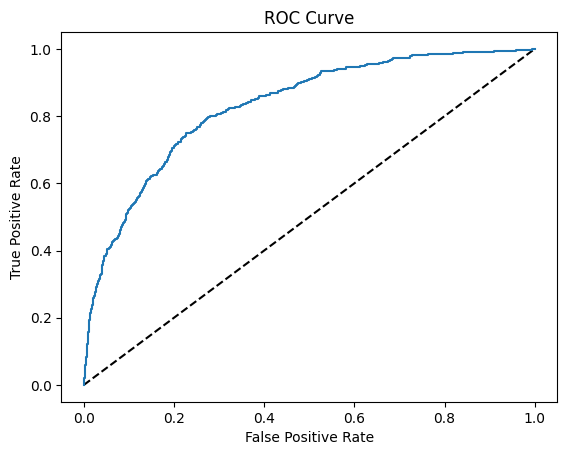

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [412]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [413]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [414]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)